In [ ]:
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

# Read Data

Let's first read in the meta data of all models in the dataset.

In [4]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.28s/it]


revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba744cbcafb46c2a52482e36498a9bf  301bfb5af53c431a830a6e435de6a590   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba744cbcafb46c2a52482e36498a9bf  8af3fc1bb4b74e7c8c4089e4921d9056   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   

                                             datetime description  \
model_id                                                            
1ba74449e9354d0c9d4798b4a6e915d0  2019-03-19 11:36:50         NaN   
1ba744cbcafb46c2a52482e36498a9bf  2020-03-23 17:26:03         NaN   
1ba7587b3191422fb03a0e9ba92cebff  2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc  2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b  2020-06-30 07:12:48         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba744cbcafb46c2a52482e36498a9bf                  Receipt of Application  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba744cbcafb46c2a52482e36498a9bf  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [5]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [6]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [7]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

60897

This is the percentage of example process from the dataset:

In [8]:
len(df_meta_examples)/len(df_meta)

0.46319720698861344

This is the number of models in the dataset without example processes (again, based on process names):

In [9]:
len(df_meta)-len(df_meta_examples)

70574

And the percentage of models in the dataset without example processes:

In [10]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5368027930113866

We apply the filter to perform the analysis on the dataset without examples processes:

In [11]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

70574

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [12]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [13]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
df_notations = df_notations.replace({'Notation' : d_namespaces})

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [14]:
df_notations = DataFilter(df_notations)
df_notations = df_notations.filter_data("namespaces", "max", 100)
df_notations

Notation  Frequency
0                BPMN 2.0      51819
1                     EPC       4120
2             Value Chain       3016
3                BPMN 1.1       2036
4           UML 2.2 Class       1918
5                 DMN 1.0       1570
6           ArchiMate 2.1       1448
7               Petri Net       1434
8            UML Use Case       1306
9   BPMN 2.0 Choreography        561
10             Organigram        552
11  BPMN 2.0 Conversation        348
12      FMC Block Diagram        167
13                  Other        159
14               CMMN 1.0        120

We can visualise the number of models in different modeling notations.

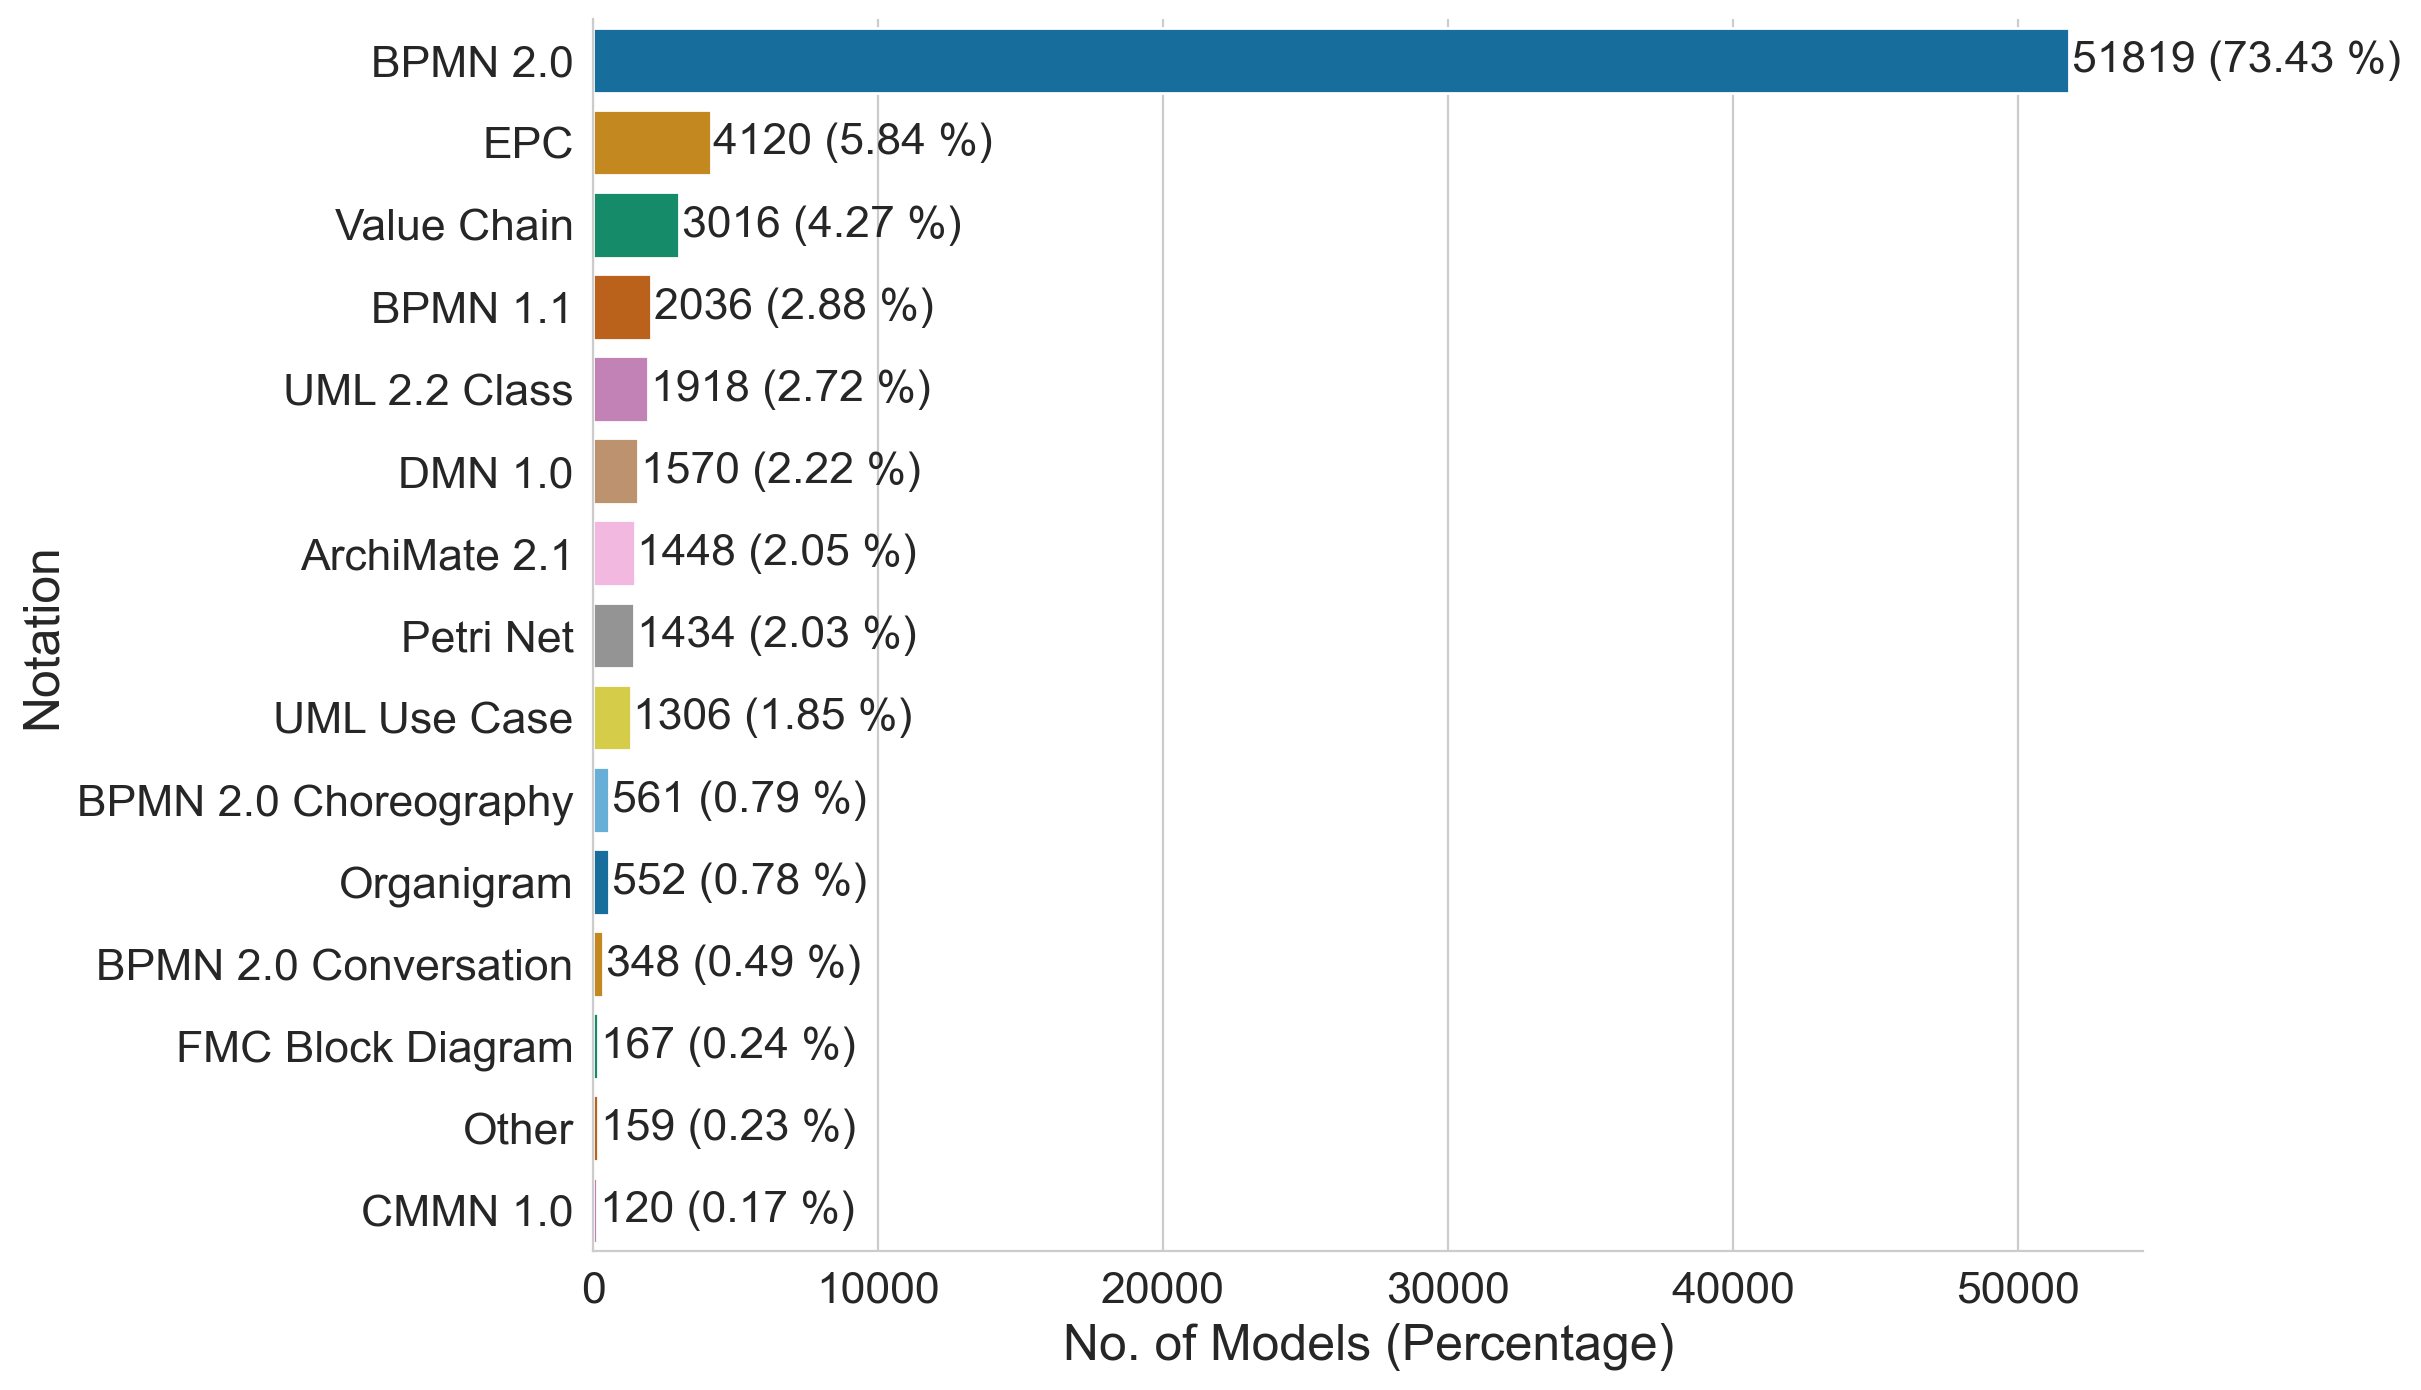

In [15]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
# ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=1, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
# ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

By using the datetime column, we can also consider the creation of models in different notations over time.

In [16]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [17]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  43fe80a91c114d3ca121e8e8fb03a0a6   

                                                   organization_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
c1f9781d06594f068bee14f96d6744f3 2011-12-01 23:11:10         NaN   

                                              name       type  \
model_id                                                        
c1f9781d06594f068bee14f96d6744f3  Ampel - Lösung 1  Petrinets   

                                                             namespace  
model_id                                                                
c1f9781d06594f068bee14f96d6744f3  http://b3mn.org/stencilset/petrinet#

In [18]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
90890b4f53b5429ba5385ad93b860301  86144360fbff44eaafc9d513542d10a2   

                                                   organization_id  \
model_id                                                             
90890b4f53b5429ba5385ad93b860301  8f45cdba3d7c4c1b814f1ab1a883e289   

                                            datetime description  \
model_id                                                           
90890b4f53b5429ba5385ad93b860301 2021-09-22 03:15:41         NaN   

                                                     name type  \
model_id                                                         
90890b4f53b5429ba5385ad93b860301  Preparar música en vivo  NaN   

                                                            namespace  
model_id                                                               
90890b4f53b5429ba5385ad93b860301  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [19]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#      51819
1                  http://b3mn.org/stencilset/epc#       4120
2  http://www.signavio.com/stencilsets/processmap#       3016
3              http://b3mn.org/stencilset/bpmn1.1#       2036
4          http://b3mn.org/stencilset/UML2.2Class#       1918

In [20]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [21]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [22]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

namespace  Count  Year
0   UML 2.2 Class     23  2015
1   UML 2.2 Class    151  2016
2   UML 2.2 Class    231  2017
3   UML 2.2 Class    201  2018
4   UML 2.2 Class    141  2019
5   UML 2.2 Class    489  2020
6   UML 2.2 Class    682  2021
7        BPMN 1.1     28  2015
8        BPMN 1.1     81  2016
9        BPMN 1.1    176  2017
10       BPMN 1.1    326  2018
11       BPMN 1.1    277  2019
12       BPMN 1.1    429  2020
13       BPMN 1.1    719  2021
14       BPMN 2.0    577  2015
15       BPMN 2.0   2236  2016
16       BPMN 2.0   5005  2017
17       BPMN 2.0   8391  2018
18       BPMN 2.0  10674  2019
19       BPMN 2.0  12041  2020
20       BPMN 2.0  12895  2021
21            EPC    183  2015
22            EPC    314  2016
23            EPC    640  2017
24            EPC    780  2018
25            EPC    728  2019
26            EPC    961  2020
27            EPC    514  2021
28    Value Chain     24  2015
29    Value Chain    177  2016
30    Value Chain    316  2017
31    Value Chain    568  2018
32    Value Chain    557  2019
33    Value Chain    860  2020
34    Value Chain    514  2021

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [23]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

4

In [24]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2021]
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class     23  2015
1  UML 2.2 Class    151  2016
2  UML 2.2 Class    231  2017
3  UML 2.2 Class    201  2018
4  UML 2.2 Class    141  2019

In [25]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

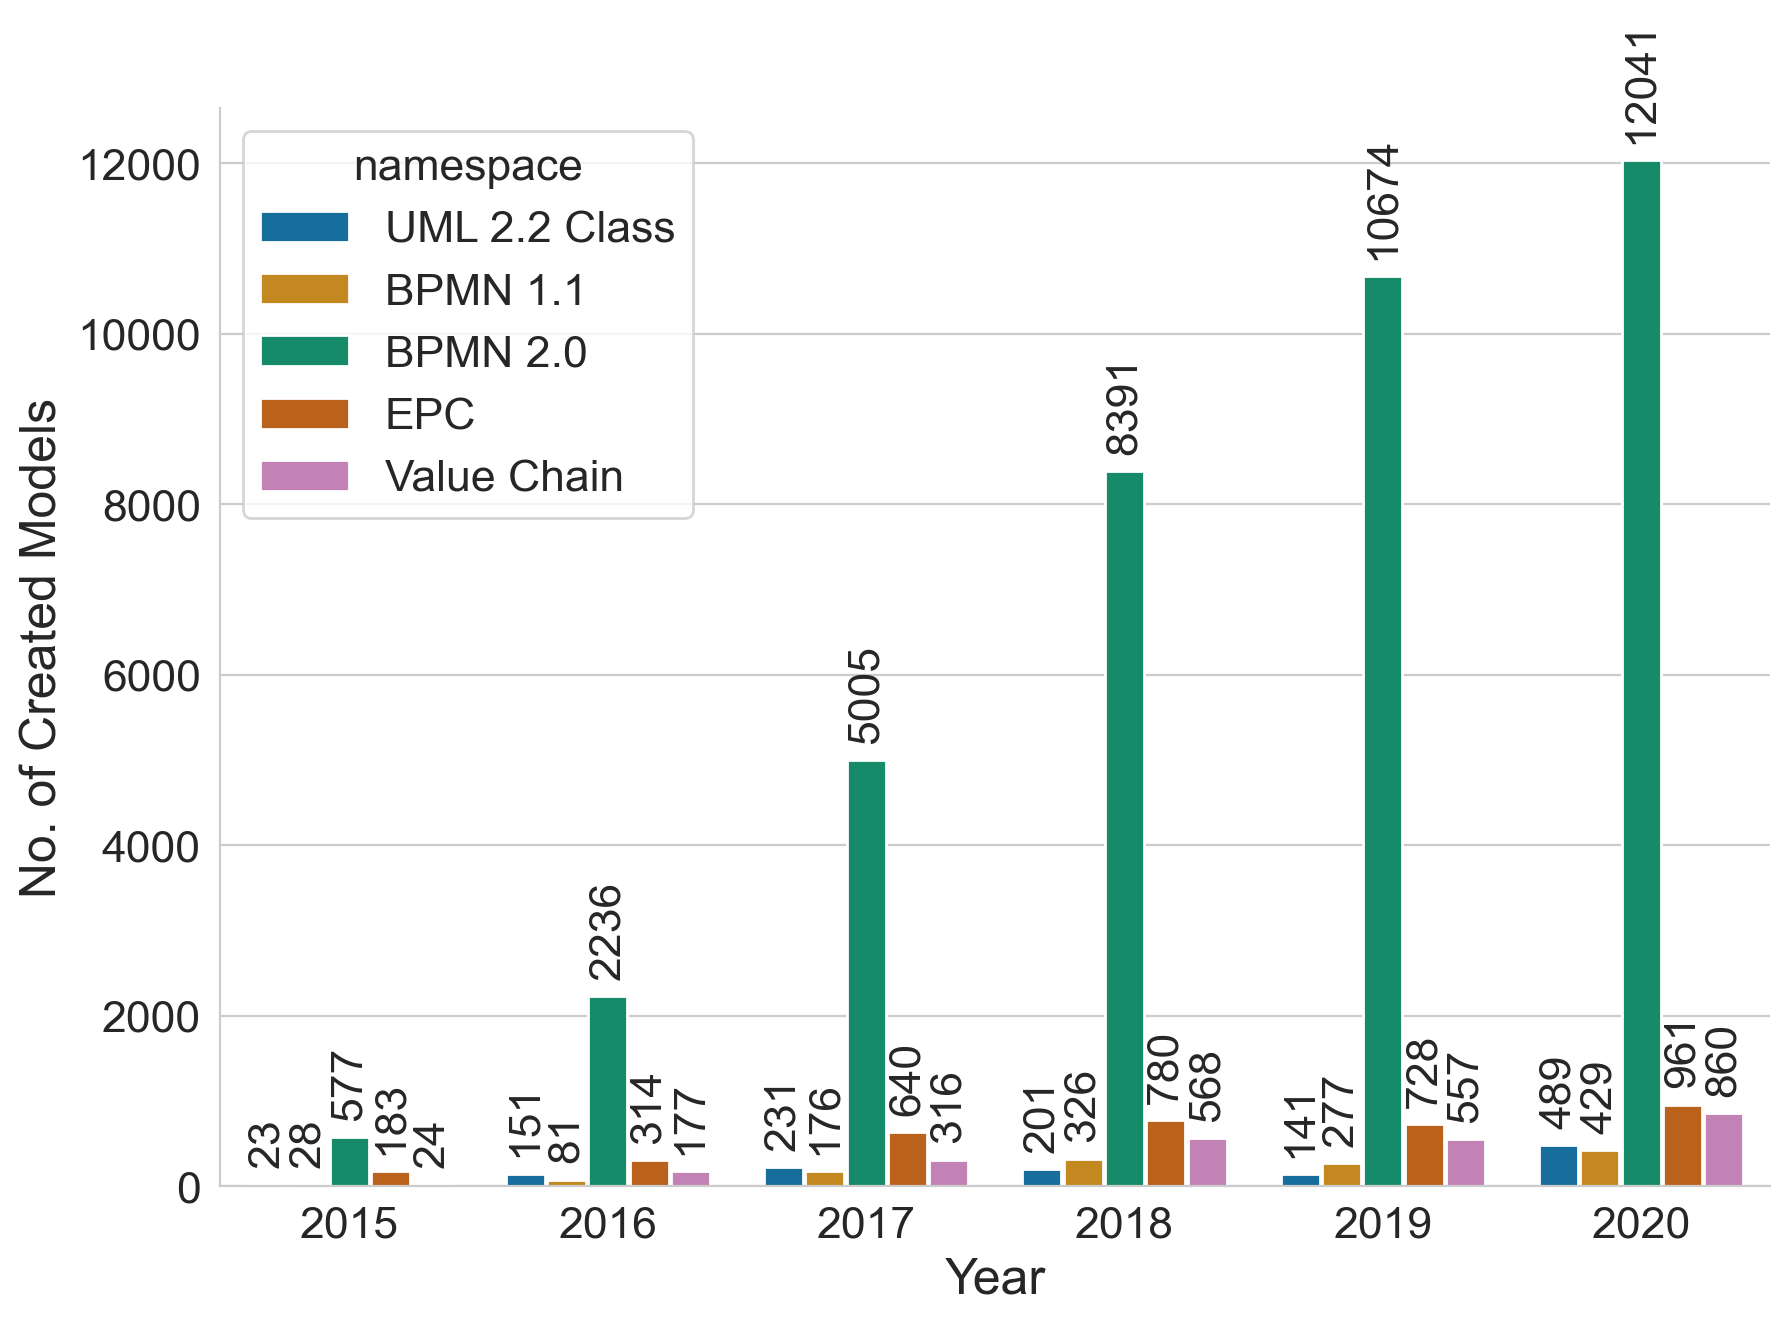

In [26]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [27]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0  EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2020     12041  961          860       429            489
2019     10674  728          557       277            141
2018      8391  780          568       326            201
2017      5005  640          316       176            231
2016      2236  314          177        81            151
2015       577  183           24        28             23

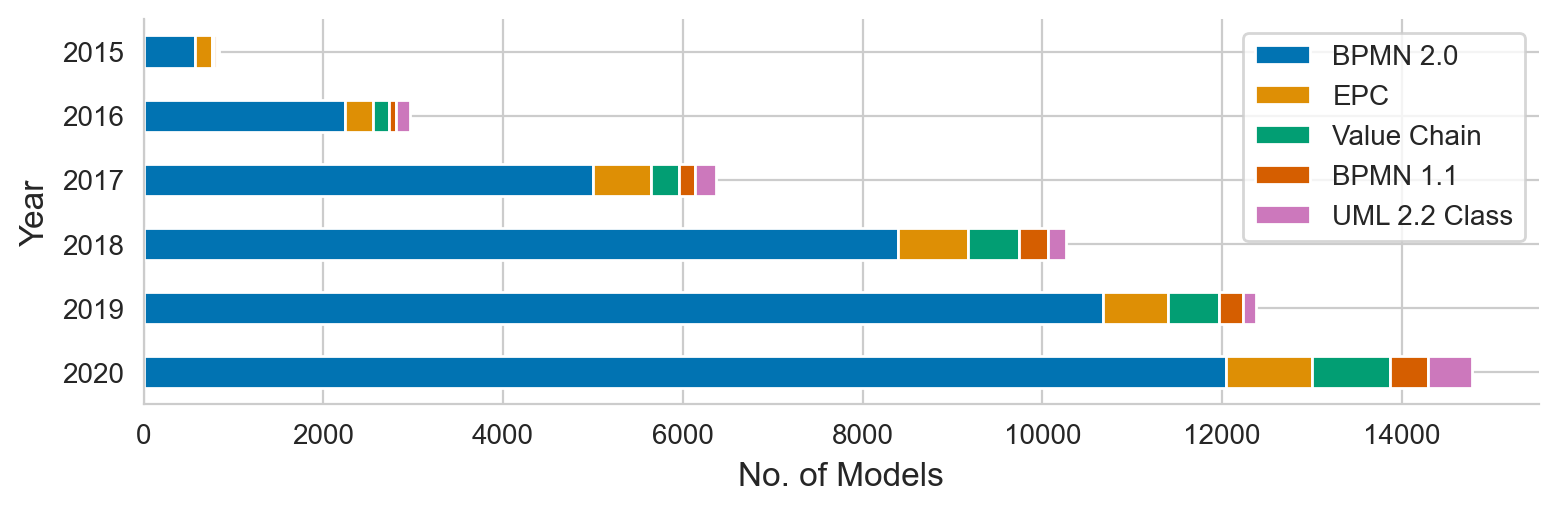

In [28]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [29]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   
1ba7b40cfd804781a4aaa394635d1760  e47efaa6dcde4a4586b7ffcb301996d5   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   
1ba7b40cfd804781a4aaa394635d1760  c41660388a04449a995dccf97d894f46   

                                            datetime description  \
model_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 2019-03-19 11:36:50         NaN   
1ba7587b3191422fb03a0e9ba92cebff 2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc 2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b 2020-06-30 07:12:48         NaN   
1ba7b40cfd804781a4aaa394635d1760 2019-06-12 03:11:21         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4  NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#  
1ba7b40cfd804781a4aaa394635d1760  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [30]:
len(df_meta_bpmn)

51819

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [31]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
# df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [02:33<00:00, 10.96s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  Pivo  
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Pivo  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  Pivo

Number of BPMN 2.0 models from the parser:

In [32]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

77629

Number of BPMN 2.0 models from the parser after filtering out example processes:

In [33]:
df_bpmn = DataFilter(df_bpmn)
df_bpmn = df_bpmn.filter_data("example_processes")
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

50151

When compared to the analysis of the dataset metadata, we notice the count of BPMN 2.0 models is slightly lower. This difference shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements, and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [34]:
len(df_bpmn)

2535068

# Business objects

To start with, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries.

In [35]:
df_bpmn.head()

category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  Pivo  
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Pivo  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  Pivo

First, we calculate and visualize the total counts of business objects in the dataset.

In [36]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [37]:
total_bos_count = len(total_bos)
total_bos_count

19099

When compared to the total number of elements, that would be about:

In [38]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.75%


Next, let's take a look at how many models have at least one glossary link.

In [39]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [40]:
len(models_w_bos)

6052

The highest number of glossary links used in one model:

In [41]:
models_w_bos.max()

99

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [42]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

10472

In [43]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

54.83%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

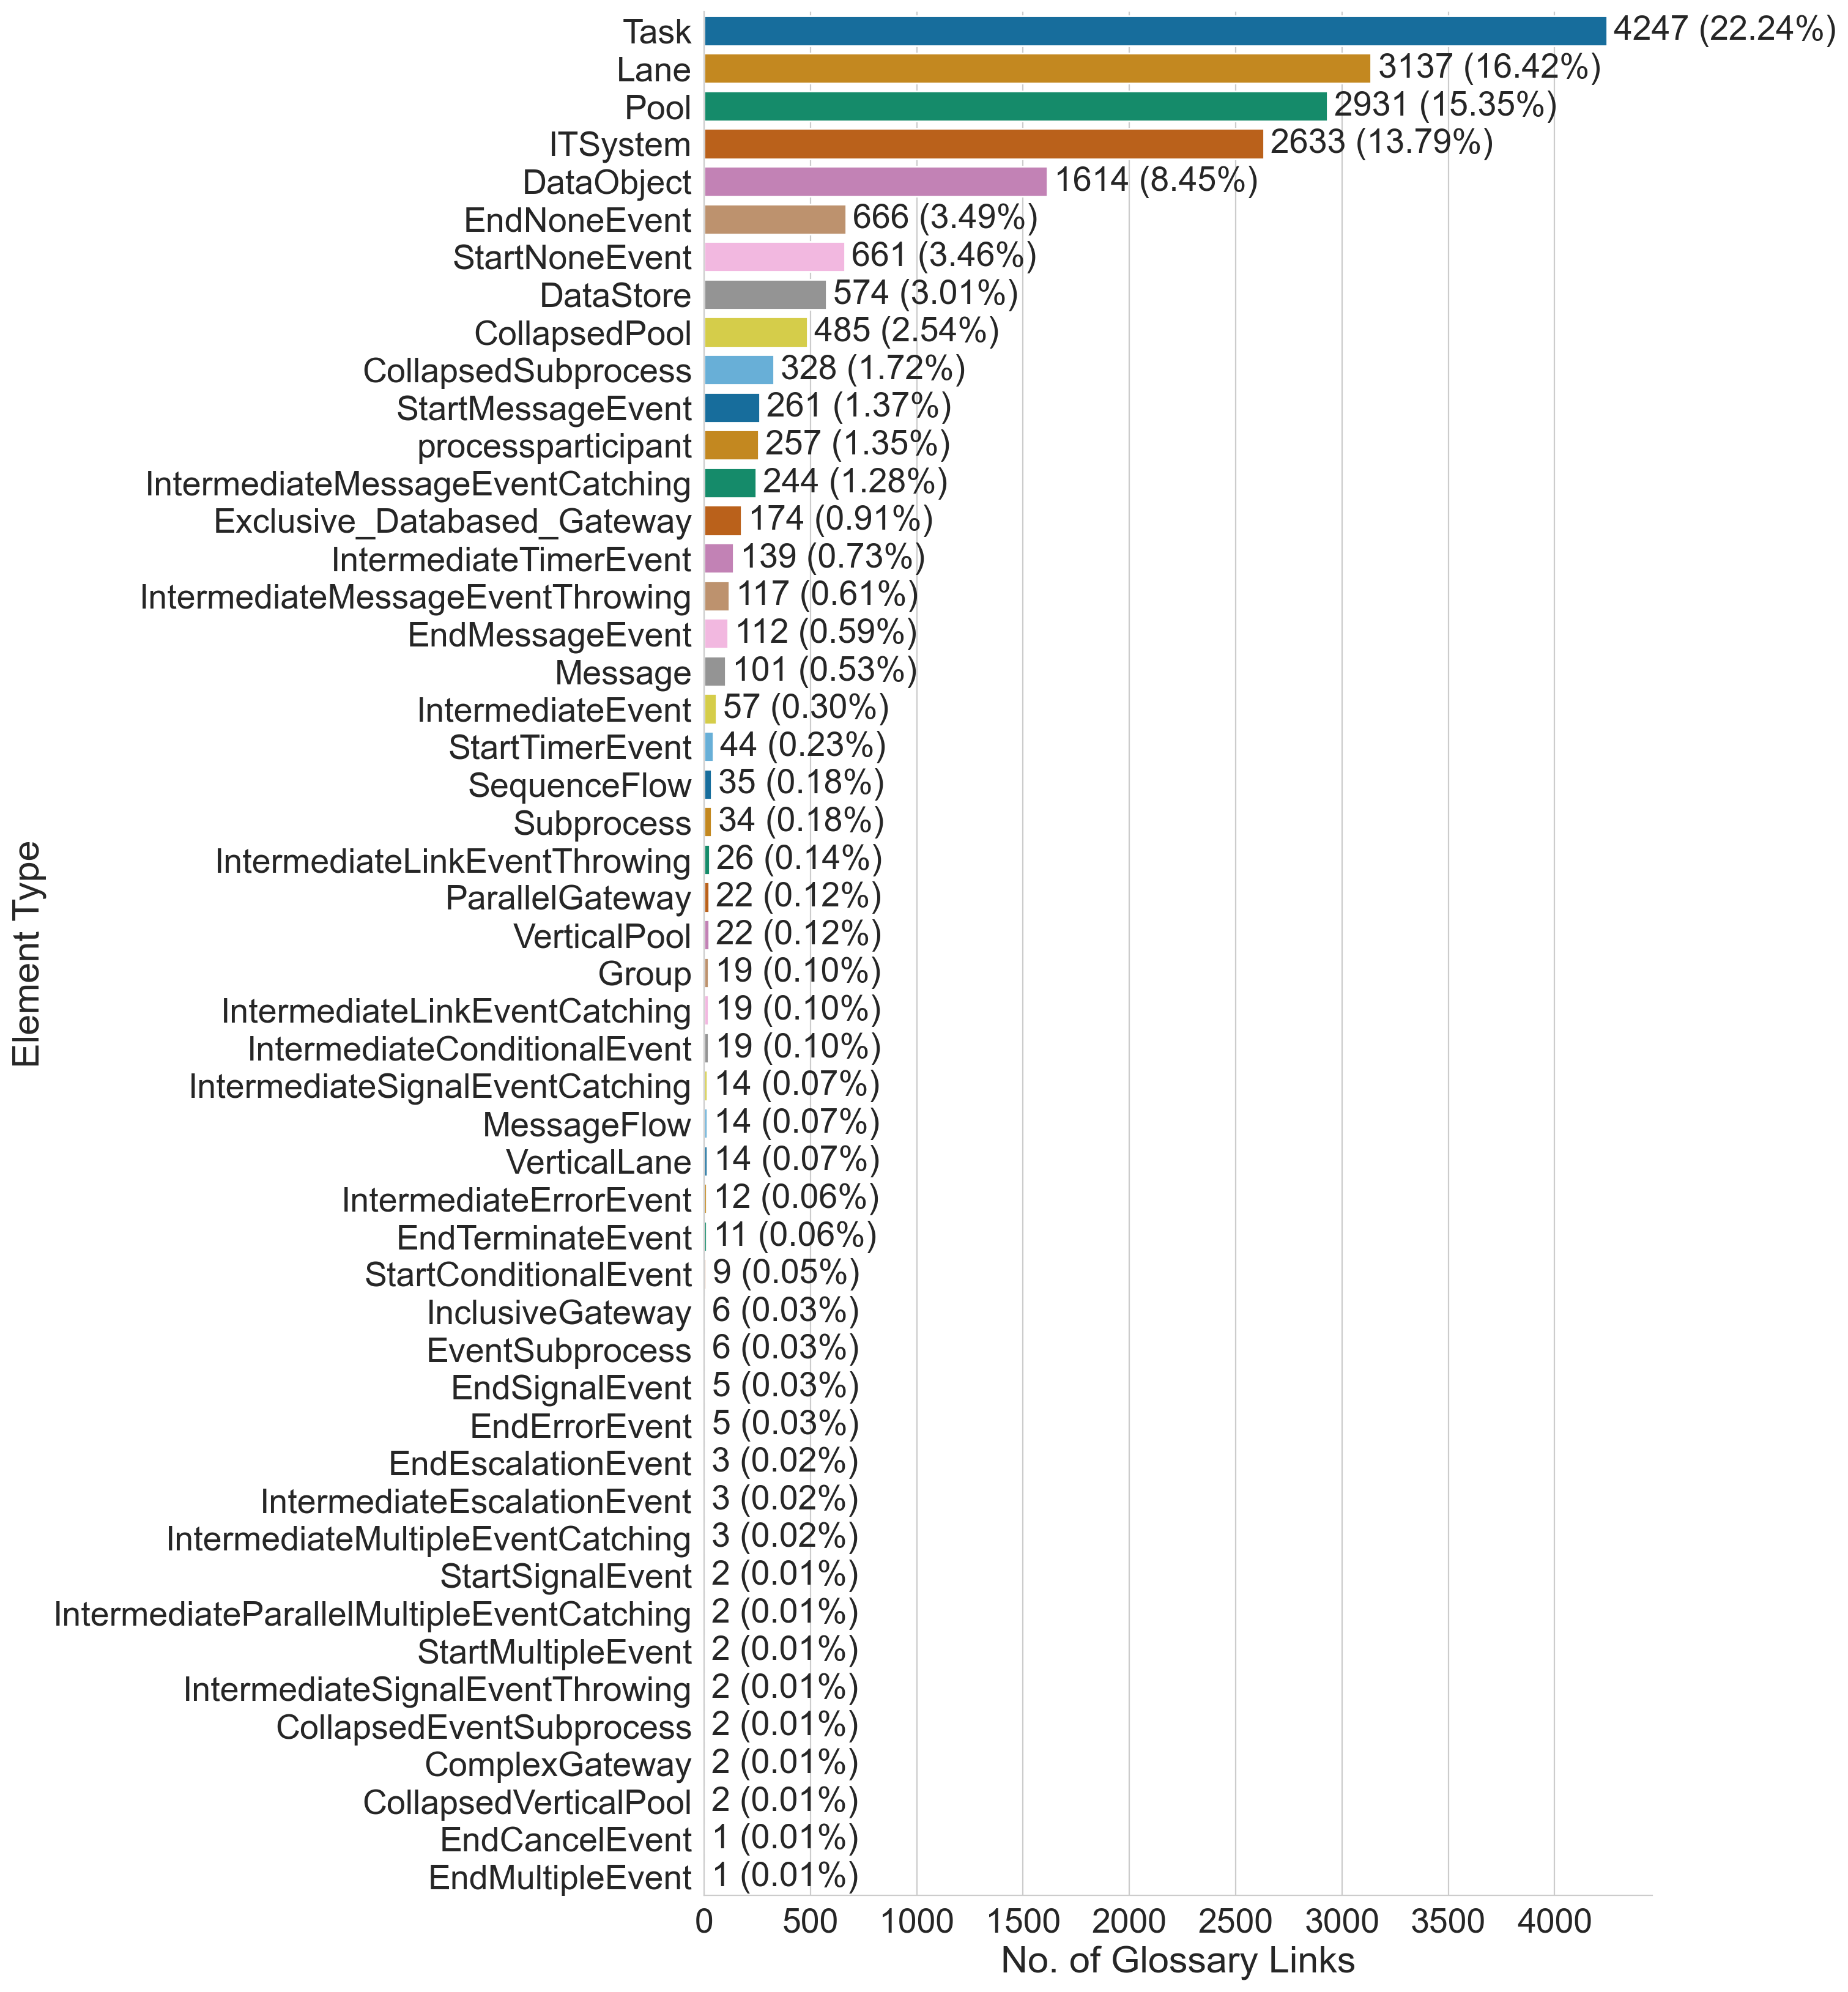

<Figure size 640x480 with 0 Axes>

In [44]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind"))
total = total_bos_count
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val.get_width()} ({val.get_width()/total*100.0:.2f}%)' for val in ax.containers[0]])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.show()
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particularly interesting category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [45]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [46]:
len(its_bos_count)

1203

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [47]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

1203


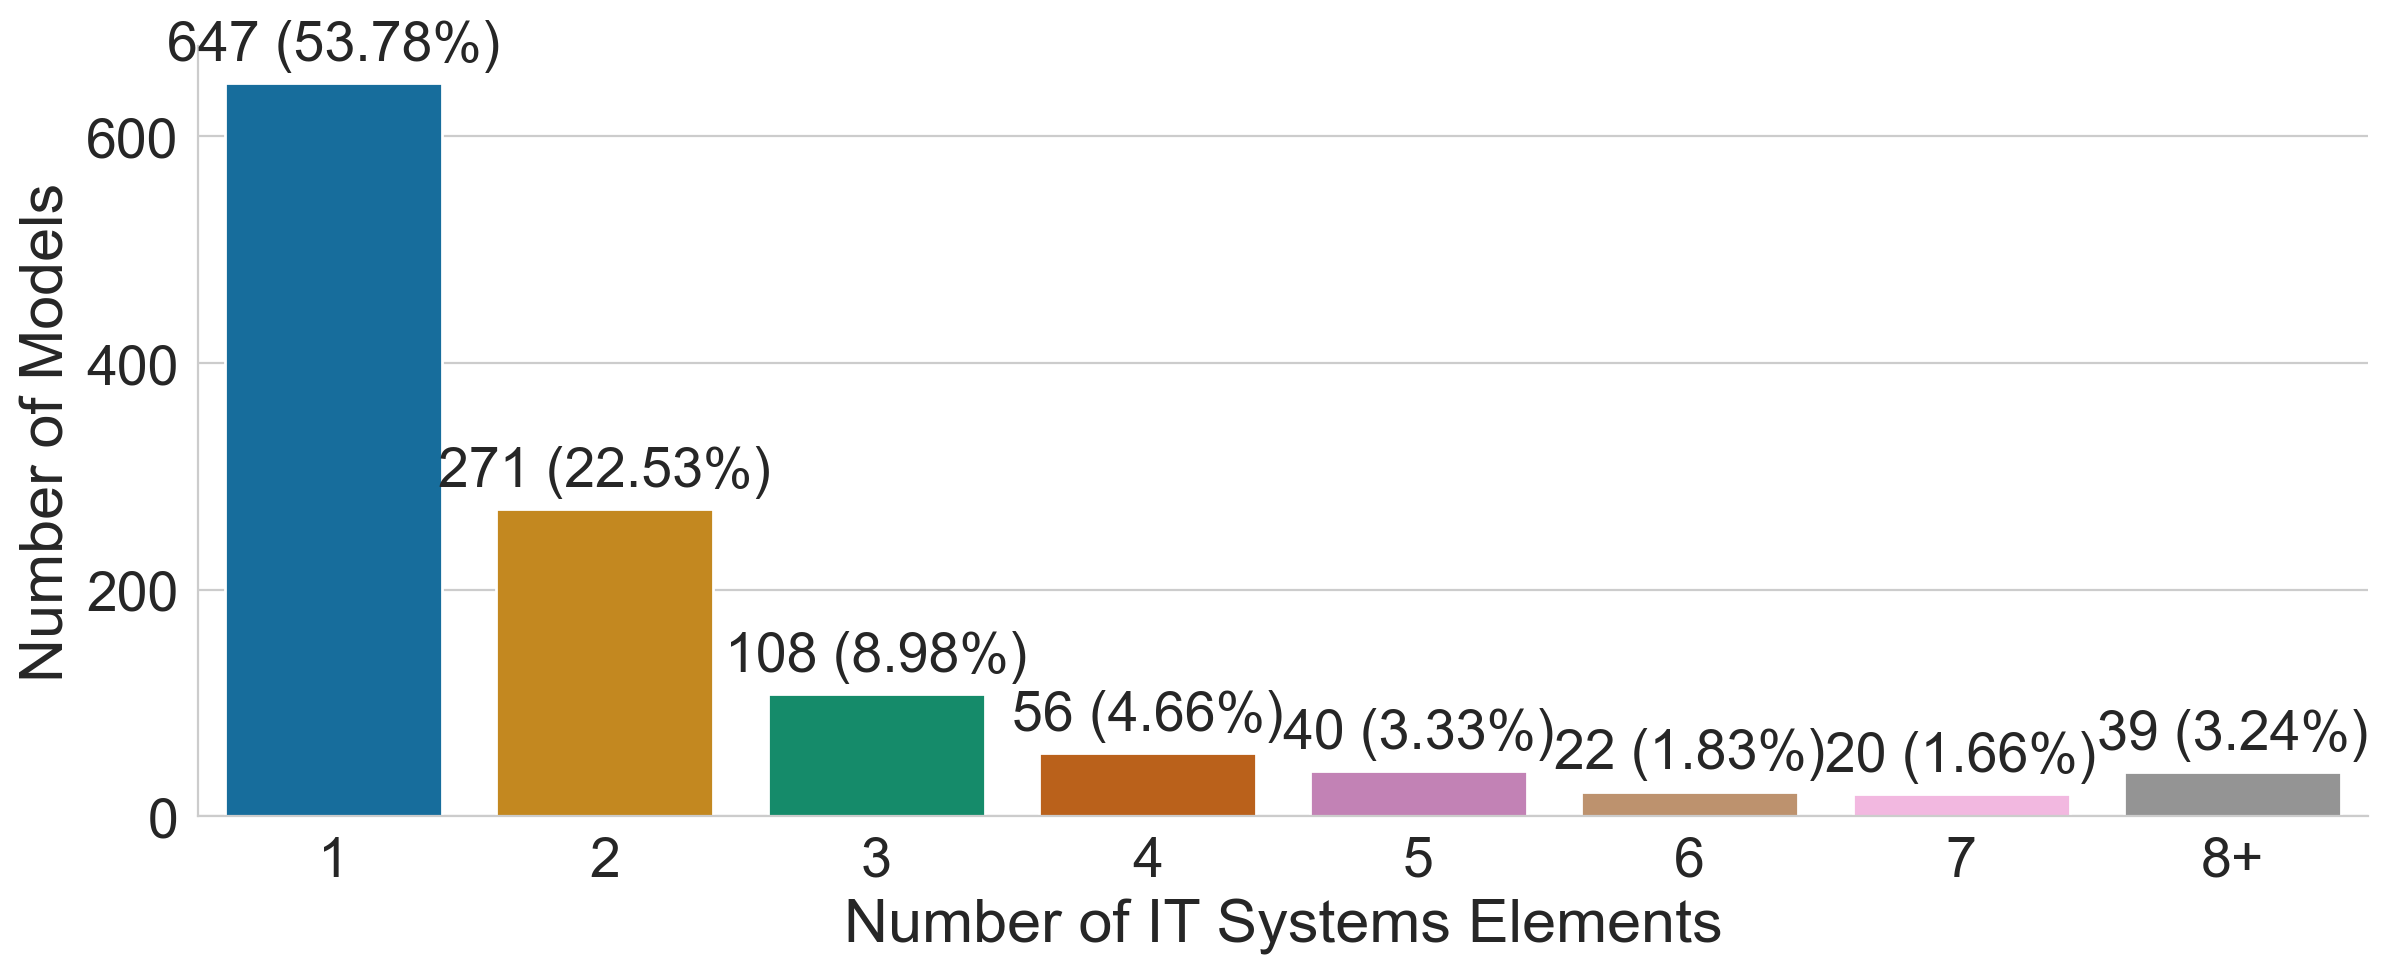

<Figure size 640x480 with 0 Axes>

In [48]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,palette=sns.color_palette("colorblind"))
total = len(its_bos_count)
print(total)
ax.bar_label(ax.containers[0],label_type='edge', padding=4,labels=[f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values])
sns.despine()
ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
ax.set_ylabel("Number of Models",fontsize=22)
plt.show()
plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [49]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

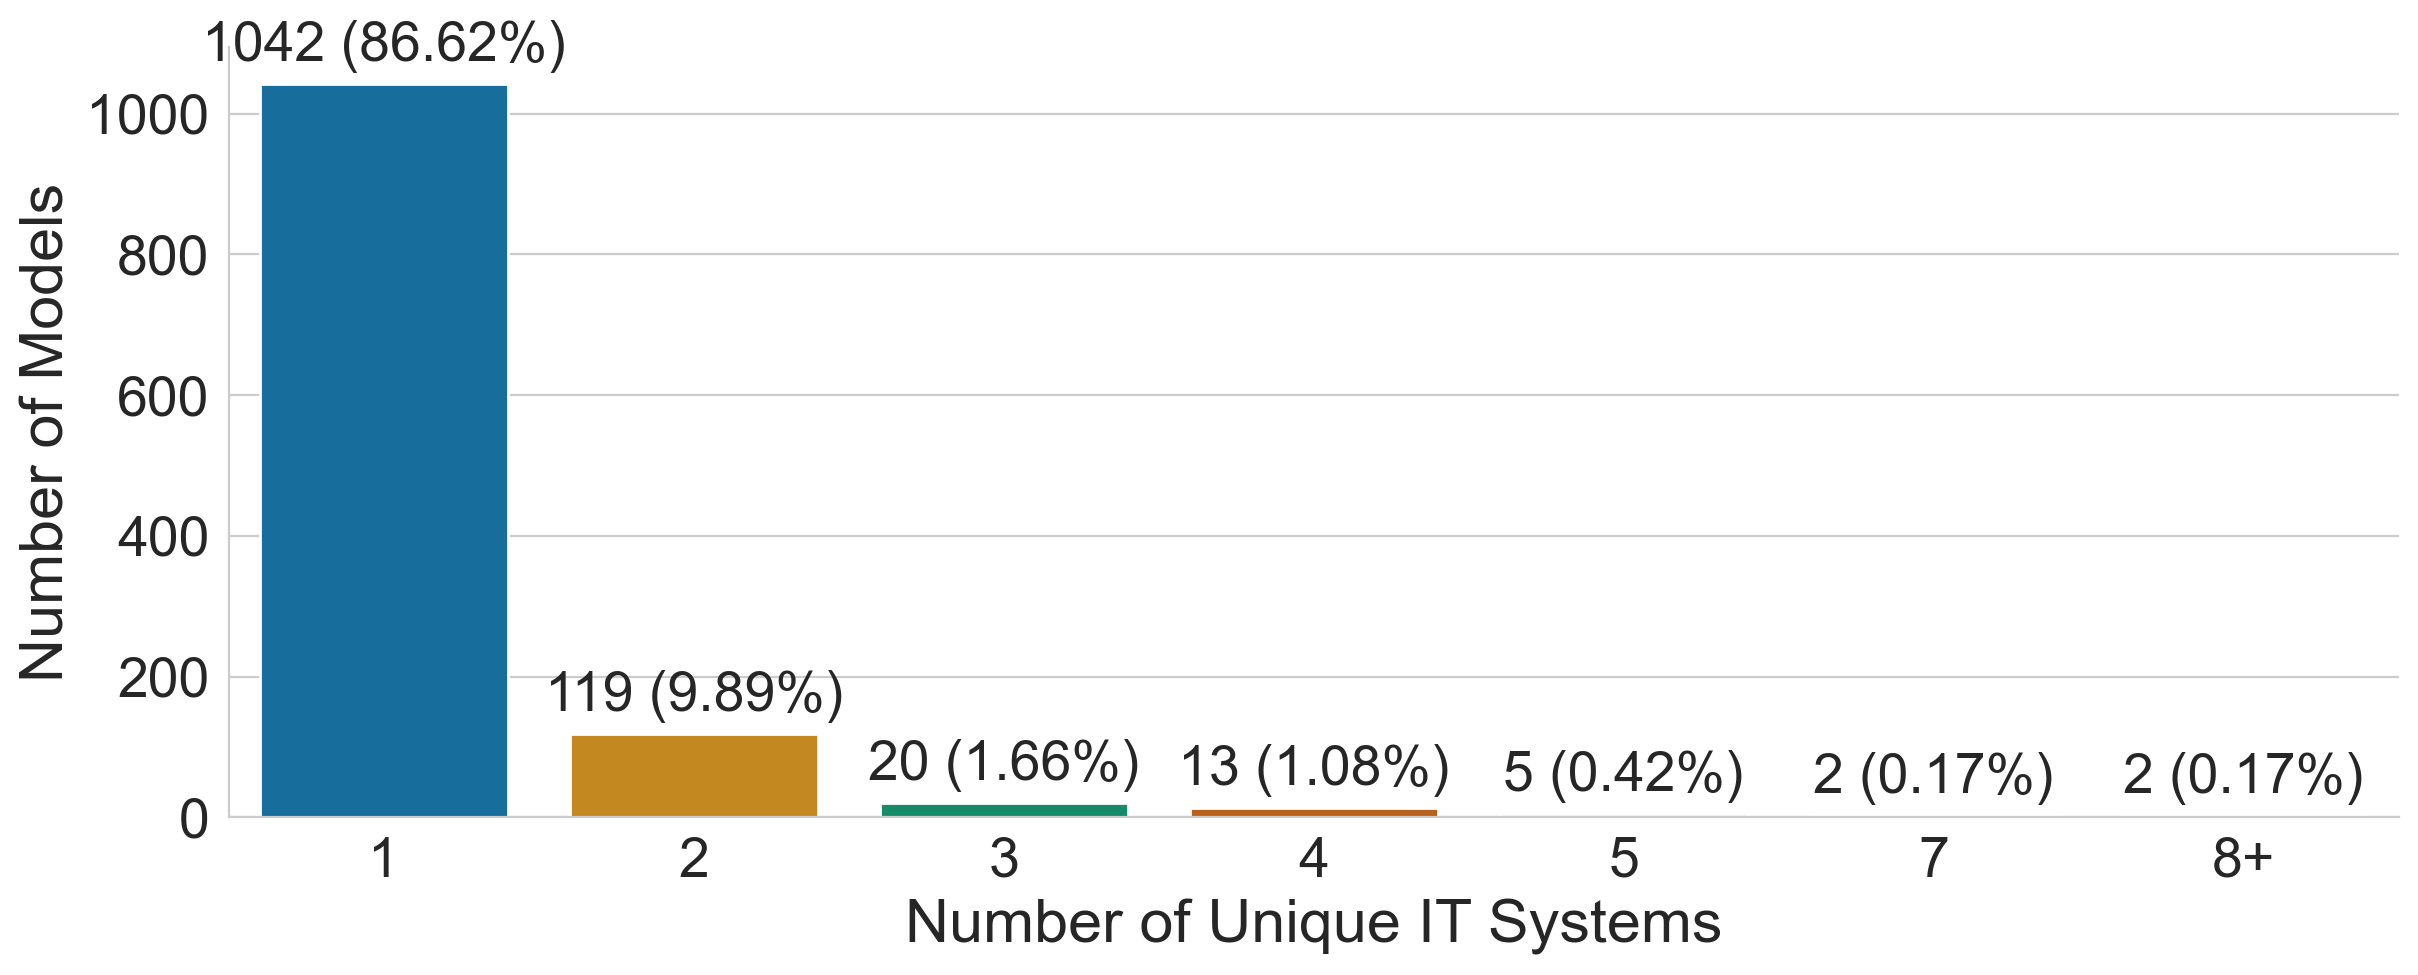

<Figure size 640x480 with 0 Axes>

In [50]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,palette=sns.color_palette("colorblind"))
total = len(its_bos)
ax.bar_label(ax.containers[0],label_type='edge',padding=4,labels=[f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values])
sns.despine()
ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
ax.set_ylabel("Number of Models",fontsize=22)
plt.show()
plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As a conclusion, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Forks

Now, let's take a look at the distribution of parallel and exclusive forks across models.

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [51]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [52]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50151/50151 [13:33<00:00, 61.63it/s]


label  \
model_id                                                                              
1ba74449e9354d0c9d4798b4a6e915d0   Konobar\n Narudžba primljena\n Narudžba / kup...   
1ba7587b3191422fb03a0e9ba92cebff   Yes No Organization\n Employee Meeting confir...   
1ba758f87e744ff0bcb3119887cac8cc   A student visits ACBT Direct to ECU SL Direct...   
1ba77121c3be44d6bd0b354727f9707b   Kunde  "DESADV"\n geht ein Auftrags-\nE-Mail ...   
1ba7b40cfd804781a4aaa394635d1760   Event Administrator Publish Event Customise E...   

                                                                    name  \
model_id                                                                   
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen    
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4   

                                 detected_natural_language  
model_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0                        hr  
1ba7587b3191422fb03a0e9ba92cebff                        en  
1ba758f87e744ff0bcb3119887cac8cc                        en  
1ba77121c3be44d6bd0b354727f9707b                        de  
1ba7b40cfd804781a4aaa394635d1760                        en

Let's plot the use of different languages across the dataset.

In [53]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [54]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English          23960
1                       German          13479
2                      Italian           2503
3                      Spanish           2248
4                       French           1187
5                     Croatian           1054
6                   Portuguese            897
7                        Dutch            605
8                     Estonian            600
9                    Slovenian            555
10  Unknown language [UNKNOWN]            531
11                    Romanian            466
12                  Indonesian            377
13                     Swedish            263
14                      Polish            208
15                       Greek            193
16                   Hungarian            186
17                      Danish             86
18                     Catalan             71
19                     Finnish             61
20                     Turkish             60
21                   Norwegian             59
22                    Japanese             57
23                   Afrikaans             57
24                  Vietnamese             57
25                       Welsh             47
26                     Tagalog             36
27                    Albanian             35
28    Unknown language [zh-cn]             32
29                       Czech             32
30                     Latvian             28
31                      Slovak             28
32                      Somali             26
33                     Russian             19
34                  Lithuanian             13
35                      Korean             13
36                  Macedonian             11
37                     Swahili              6
38                     Persian              5

We only plot the 10 most common languages.

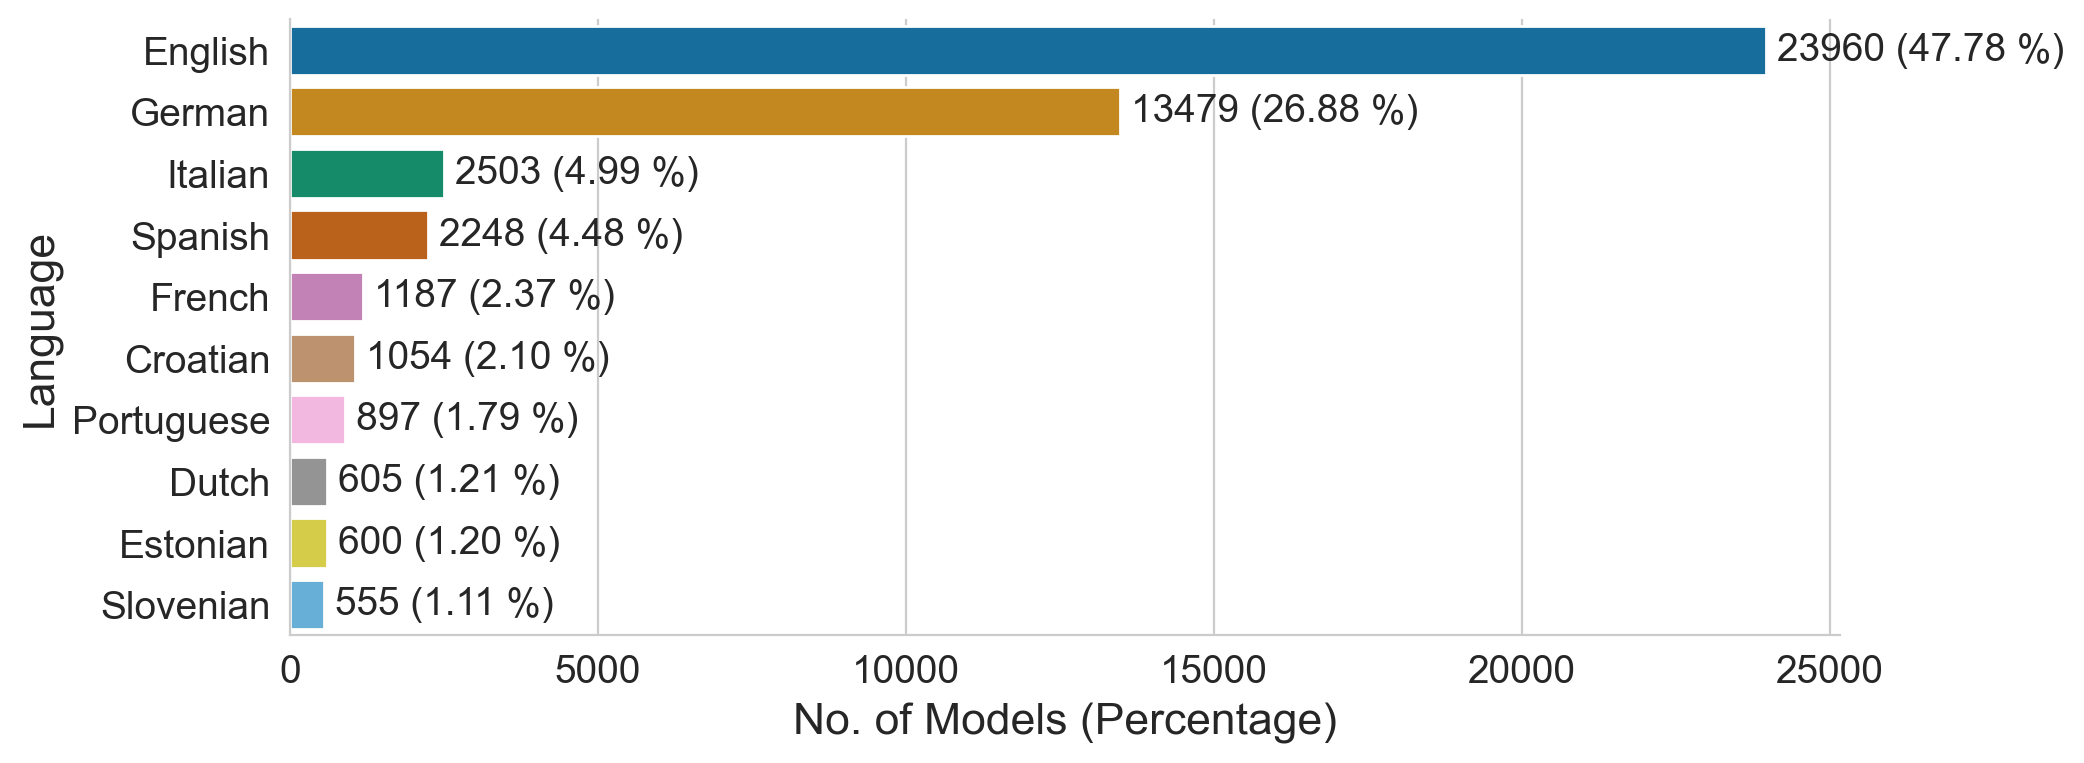

In [55]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Now we want to examine the usage of element types in the BPMN models.

In [56]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [57]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50151/50151 [03:06<00:00, 268.59it/s]


MessageFlow  Pool  Lane  StartMessageEvent  SequenceFlow  \
0            1     2     2                  1             2   
1            0     1     3                  0            17   
2            0     0     0                  0             6   
3            1     2     5                  0            25   
4            0     1     1                  0             5   

   EventbasedGateway  Task  StartNoneEvent  total_count  EndNoneEvent  \
0                  1     2               1           12             0   
1                  0    12               1           38             2   
2                  0     6               0           13             0   
3                  0    12               1           66             4   
4                  0     0               1           13             1   

   Exclusive_Databased_Gateway  Association_Undirected  \
0                            0                       0   
1                            2                       0   
2                            1                       0   
3                            0                       2   
4                            0                       0   

   Association_Unidirectional  IntermediateMessageEventCatching  \
0                           0                                 0   
1                           0                                 0   
2                           0                                 0   
3                           1                                 1   
4                           0                                 0   

   IntermediateMessageEventThrowing  ITSystem  ParallelGateway  \
0                                 0         0                0   
1                                 0         0                0   
2                                 0         0                0   
3                                 2         2                3   
4                                 0         0                0   

   StartConditionalEvent  DataObject  IntermediateConditionalEvent  \
0                      0           0                             0   
1                      0           0                             0   
2                      0           0                             0   
3                      3           1                             1   
4                      0           0                             0   

   CollapsedSubprocess  EndTerminateEvent  IntermediateTimerEvent  \
0                    0                  0                       0   
1                    0                  0                       0   
2                    0                  0                       0   
3                    0                  0                       0   
4                    4                  0                       0   

   CollapsedPool  TextAnnotation  Subprocess  IntermediateEvent  \
0              0               0           0                  0   
1              0               0           0                  0   
2              0               0           0                  0   
3              0               0           0                  0   
4              0               0           0                  0   

   InclusiveGateway  DataStore  EndMessageEvent  EventSubprocess  \
0                 0          0                0                0   
1                 0          0                0                0   
2                 0          0                0                0   
3                 0          0                0                0   
4                 0          0                0                0   

   StartTimerEvent  IntermediateErrorEvent  IntermediateLinkEventCatching  \
0                0                       0                              0   
1                0                       0                              0   
2                0                       0                              0   
3                0                       0                              0   
4  

These are the statistics of the different element types per model:

In [58]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    50151.000000
mean         9.936611
std          4.164139
min          1.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         40.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [59]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0a1ef88d340b4d6d9d5faec06083ca60                          0   
0a1f112af2a7492daffec5bb0e96be40                          0   
0a1f37872dcb490682b5cb4c5bdcc7a2                          0   
0a1f6515f7cb4da98ff9534b5340bb7e                          0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                          0   

category                          Association_Undirected  \
model_id                                                   
0a1ef88d340b4d6d9d5faec06083ca60                       0   
0a1f112af2a7492daffec5bb0e96be40                       0   
0a1f37872dcb490682b5cb4c5bdcc7a2                       1   
0a1f6515f7cb4da98ff9534b5340bb7e                       0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                       1   

category                          Association_Unidirectional  \
model_id                                                       
0a1ef88d340b4d6d9d5faec06083ca60                           0   
0a1f112af2a7492daffec5bb0e96be40                           2   
0a1f37872dcb490682b5cb4c5bdcc7a2                           0   
0a1f6515f7cb4da98ff9534b5340bb7e                           0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                           0   

category                          ChoreographyParticipant  ChoreographyTask  \
model_id                                                                      
0a1ef88d340b4d6d9d5faec06083ca60                        0                 0   
0a1f112af2a7492daffec5bb0e96be40                        0                 0   
0a1f37872dcb490682b5cb4c5bdcc7a2                        0                 0   
0a1f6515f7cb4da98ff9534b5340bb7e                        0                 0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                        0                 0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0a1ef88d340b4d6d9d5faec06083ca60                         0              0   
0a1f112af2a7492daffec5bb0e96be40                         0              0   
0a1f37872dcb490682b5cb4c5bdcc7a2                         0              1   
0a1f6515f7cb4da98ff9534b5340bb7e                         0              3   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0a1ef88d340b4d6d9d5faec06083ca60                    0                      0   
0a1f112af2a7492daffec5bb0e96be40                    0                      0   
0a1f37872dcb490682b5cb4c5bdcc7a2                    1                      0   
0a1f6515f7cb4da98ff9534b5340bb7e                    0                      0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                    0                      0   

category                          Communication  ComplexGateway  \
model_id                                                          
0a1ef88d340b4d6d9d5faec06083ca60              0               0   
0a1f112af2a7492daffec5bb0e96be40              0               0   
0a1f37872dcb490682b5cb4c5bdcc7a2              0               0   
0a1f6515f7cb4da98ff9534b5340bb7e              0               0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c              0               0   

category                          ConversationLink  DataObject  DataStore  \
model_id                                                                    
0a1ef88d340b4d6d9d5faec06083ca60                 0           0          0   
0a1f112af2a7492daffec5bb0e96be40                 0           0          0   
0a1f37872dcb490682b5cb4c5bdcc7a2                 0           0          0   
0a1f6515f7cb4da98ff9534b5340bb7e                 0           0          0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                 0           0          0   

category               

In [60]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [61]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

47

In [62]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

category  frequency
0                  Sequence flow      49269
1                           Task      48666
2                 End none event      44112
3               Start none event      38394
4  Exclusive  databased  gateway      37490

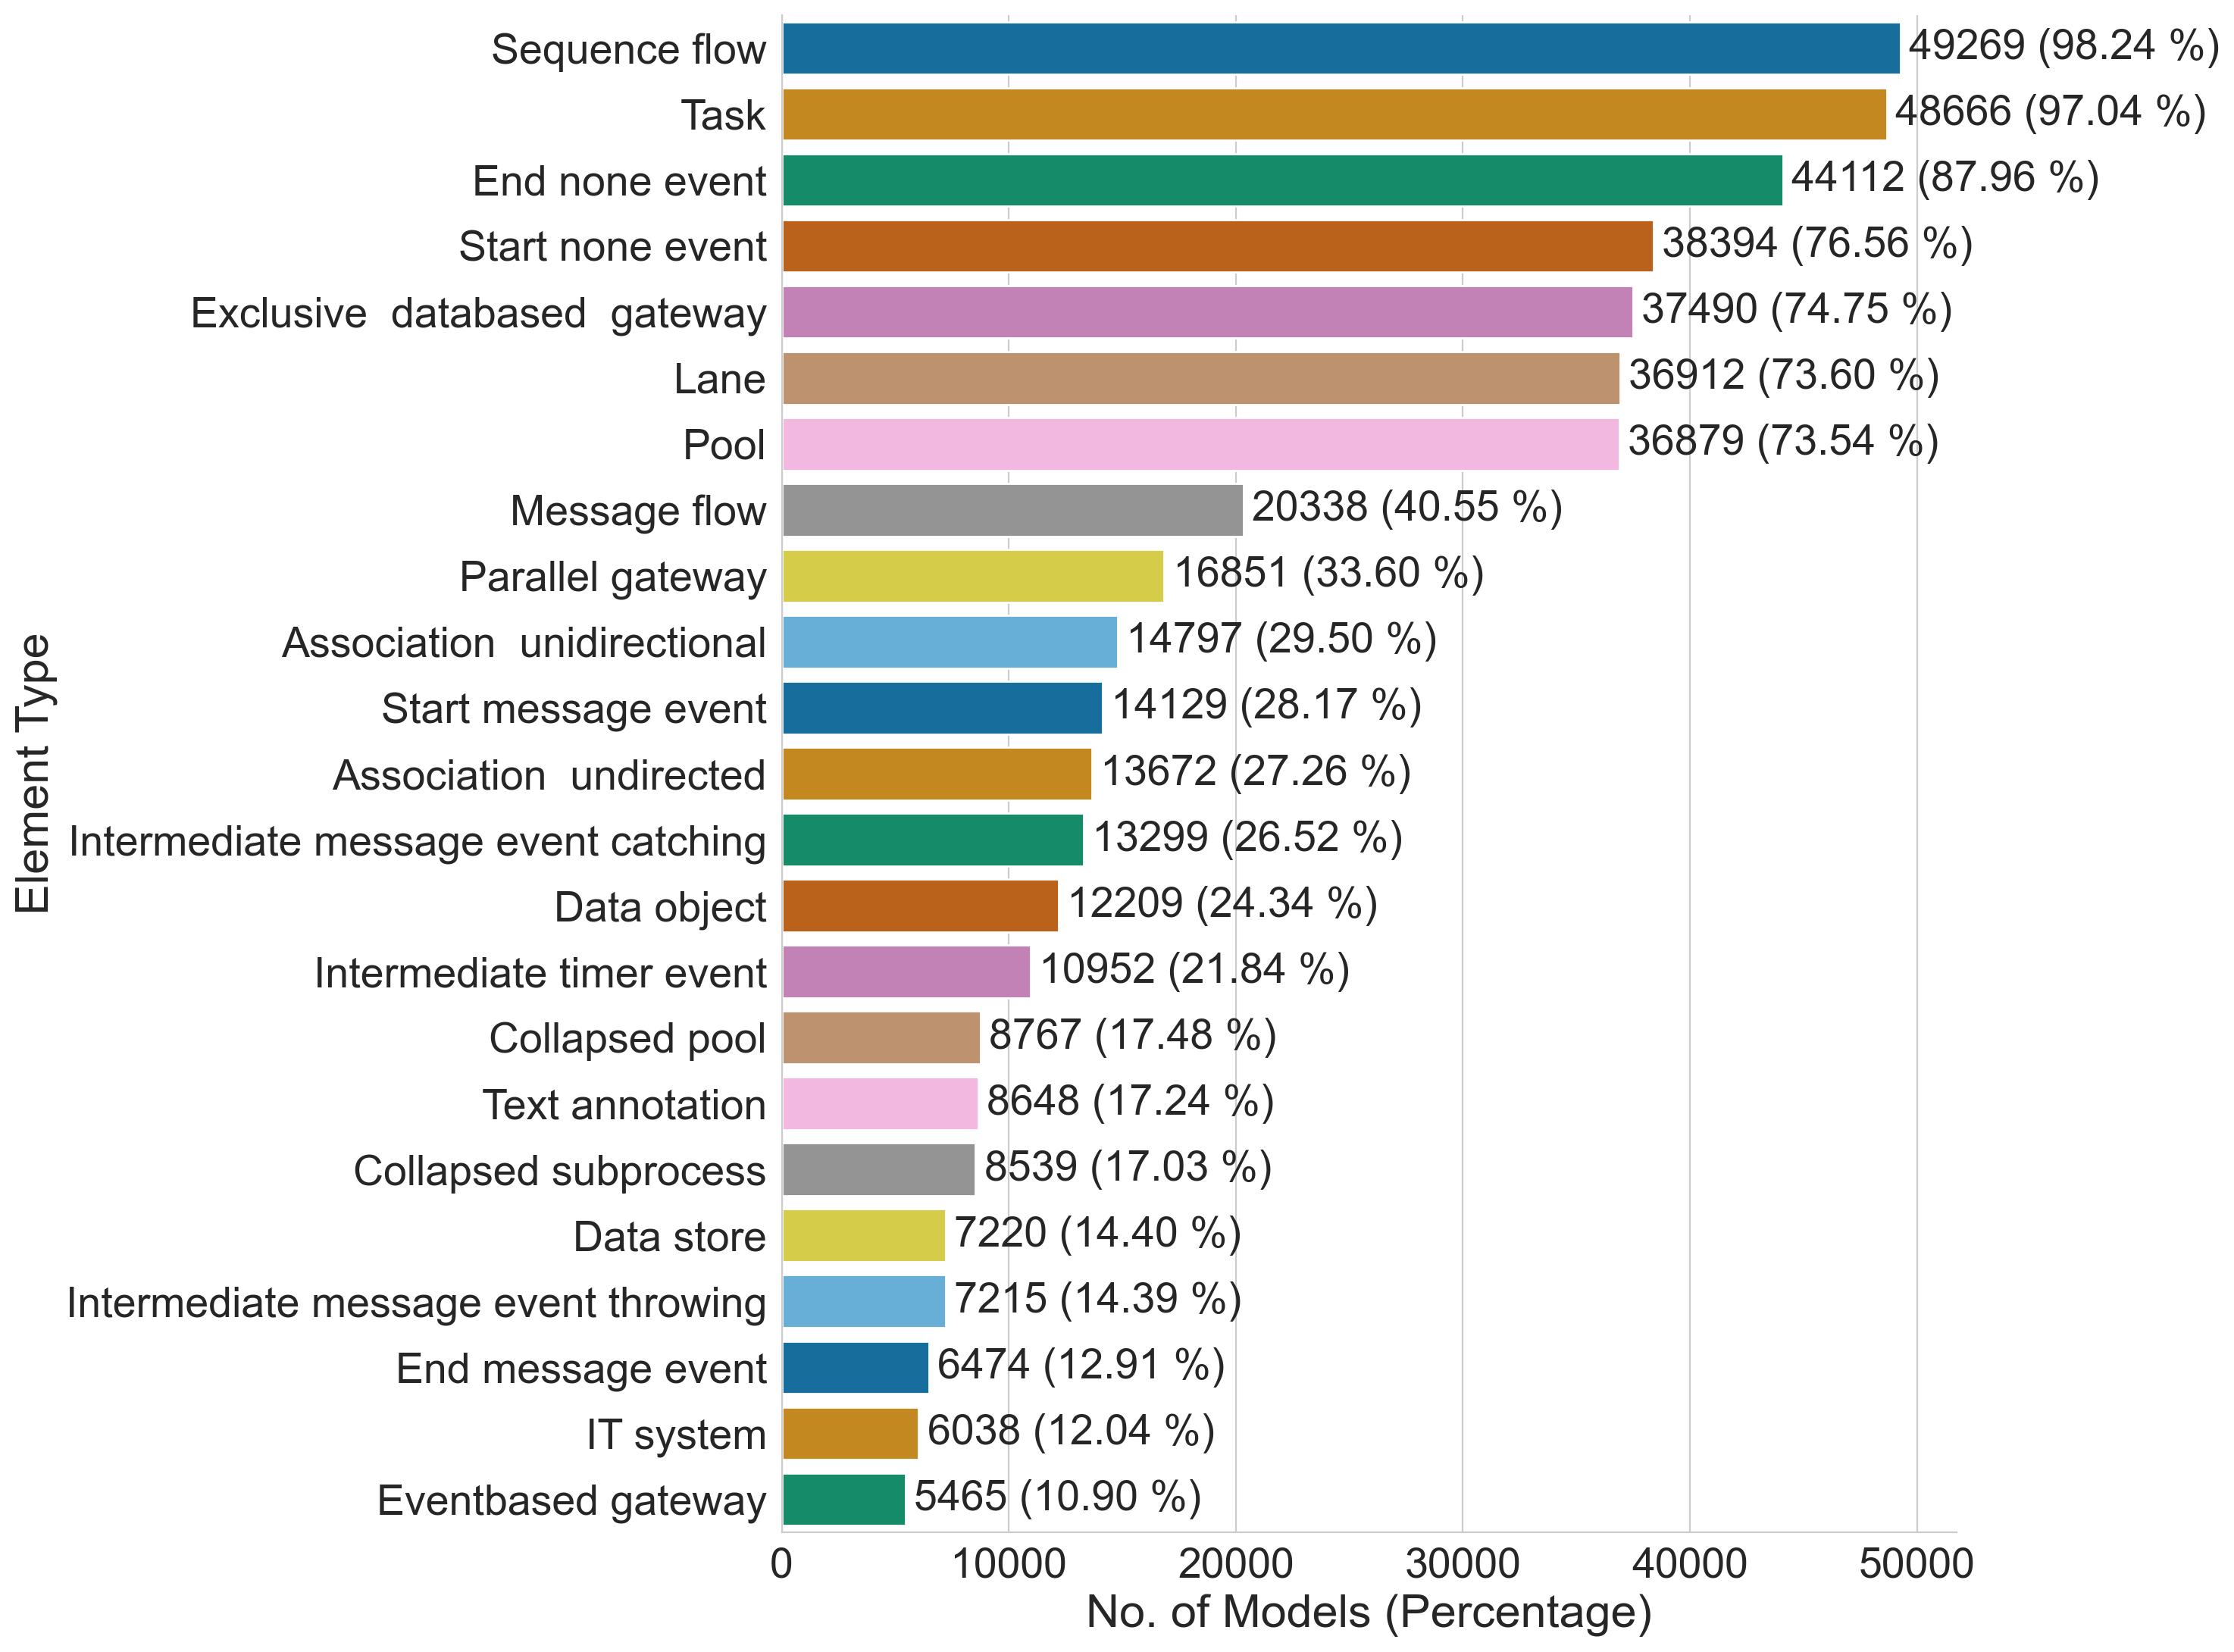

In [63]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Elements

These are the statistics of the number of elements per model:

In [64]:
cnt_elements.total_count.describe()

count    50151.000000
mean        50.548703
std         50.213019
min          1.000000
25%         22.000000
50%         38.000000
75%         63.000000
max       2611.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [65]:
cnt_elements.describe().transpose()

count       mean        std  min  \
MessageFlow                                50151.0   2.026739   3.736263  0.0   
Pool                                       50151.0   1.171362   1.114442  0.0   
Lane                                       50151.0   2.119758   2.115483  0.0   
StartMessageEvent                          50151.0   0.407190   0.941814  0.0   
SequenceFlow                               50151.0  19.925844  19.410230  0.0   
EventbasedGateway                          50151.0   0.164643   0.590647  0.0   
Task                                       50151.0   9.567666   9.318174  0.0   
StartNoneEvent                             50151.0   0.927280   0.837741  0.0   
total_count                                50151.0  50.548703  50.213019  1.0   
EndNoneEvent                               50151.0   1.764591   1.764719  0.0   
Exclusive_Databased_Gateway                50151.0   2.938645   4.276878  0.0   
Association_Undirected                     50151.0   1.204562   5.269677  0.0   
Association_Unidirectional                 50151.0   1.569899   4.632799  0.0   
IntermediateMessageEventCatching           50151.0   0.770134   2.009599  0.0   
IntermediateMessageEventThrowing           50151.0   0.404159   1.431849  0.0   
ITSystem                                   50151.0   0.363821   1.639527  0.0   
ParallelGateway                            50151.0   0.864589   1.667228  0.0   
StartConditionalEvent                      50151.0   0.017467   0.185984  0.0   
DataObject                                 50151.0   0.977887   3.583919  0.0   
IntermediateConditionalEvent               50151.0   0.041435   0.402680  0.0   
CollapsedSubprocess                        50151.0   0.400132   1.279079  0.0   
EndTerminateEvent                          50151.0   0.093438   0.490145  0.0   
IntermediateTimerEvent                     50151.0   0.398636   1.014535  0.0   
CollapsedPool                              50151.0   0.261750   0.696709  0.0   
TextAnnotation                             50151.0   0.619449   4.459473  0.0   
Subprocess                                 50151.0   0.110965   0.556722  0.0   
IntermediateEvent                          50151.0   0.077426   0.722469  0.0   
InclusiveGateway                           50151.0   0.161532   0.678254  0.0   
DataStore                                  50151.0   0.312536   1.150069  0.0   
EndMessageEvent                            50151.0   0.235947   0.811496  0.0   
EventSubprocess                            50151.0   0.028494   0.344629  0.0   
StartTimerEvent                            50151.0   0.074874   0.350981  0.0   
IntermediateErrorEvent                     50151.0   0.061295   0.363751  0.0   
IntermediateLinkEventCatching              50151.0   0.017228   0.186542  0.0   
IntermediateLinkEventThrowing              50151.0   0.020079   0.216966  0.0   
Message                                    50151.0   0.104006   0.824494  0.0   
Group                                      50151.0   0.024546   0.360203  0.0   
processparticipant                         50151.0   0.048055   0.603119  0.0   
Association_Bidirectional                  50151.0   0.043668   0.488315  0.0   
IntermediateEscalationEvent                50151.0   0.010648   0.143334  0.0   
EndEscalationEvent                         50151.0   0.007916   0.108268  0.0   
EndErrorEvent                              50151.0   0.032263   0.230816  0.0   
IntermediateMultipleEventCatching          50151.0   0.009491   0.124512  0.0   
IntermediateSignalEventThrowing            50151.0   0.012881   0.253929  0.0   
StartMultipleEvent                         50151.0   0.004925   0.081582  0.0   
EndSignalEvent                             50151.0   0.011366   0.204901  0.0   
StartSignalEvent                           50151.0   0.009671   0.128982  0.0   
IntermediateCancelEvent                    50151.0   0.006939   0.193699  0.0   
IntermediateCompensationEventCatching      50151.0   0.013719   0.179429  0.

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [66]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [67]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%  \
Activities          50151.0  10.111164   9.574159  0.0   4.0   8.0  13.0   
Artifacts           50151.0   1.007816   4.857049  0.0   0.0   0.0   1.0   
Connecting Objects  50151.0  24.770712  26.458218  0.0  10.0  18.0  31.0   
Data Elements       50151.0   1.394429   4.127120  0.0   0.0   0.0   1.0   
Events              50151.0   5.494866   6.288093  0.0   2.0   3.0   6.0   

                       max  
Activities           259.0  
Artifacts            529.0  
Connecting Objects  1393.0  
Data Elements        266.0  
Events               156.0

In [68]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%     max
Activities          10.1   9.6  0.0   4.0   8.0  13.0   259.0
Artifacts            1.0   4.9  0.0   0.0   0.0   1.0   529.0
Connecting Objects  24.8  26.5  0.0  10.0  18.0  31.0  1393.0
Data Elements        1.4   4.1  0.0   0.0   0.0   1.0   266.0
Events               5.5   6.3  0.0   2.0   3.0   6.0   156.0
Gateways             4.1   5.3  0.0   1.0   3.0   6.0   251.0
Swimlanes            3.6   3.2  0.0   0.0   4.0   5.0   156.0

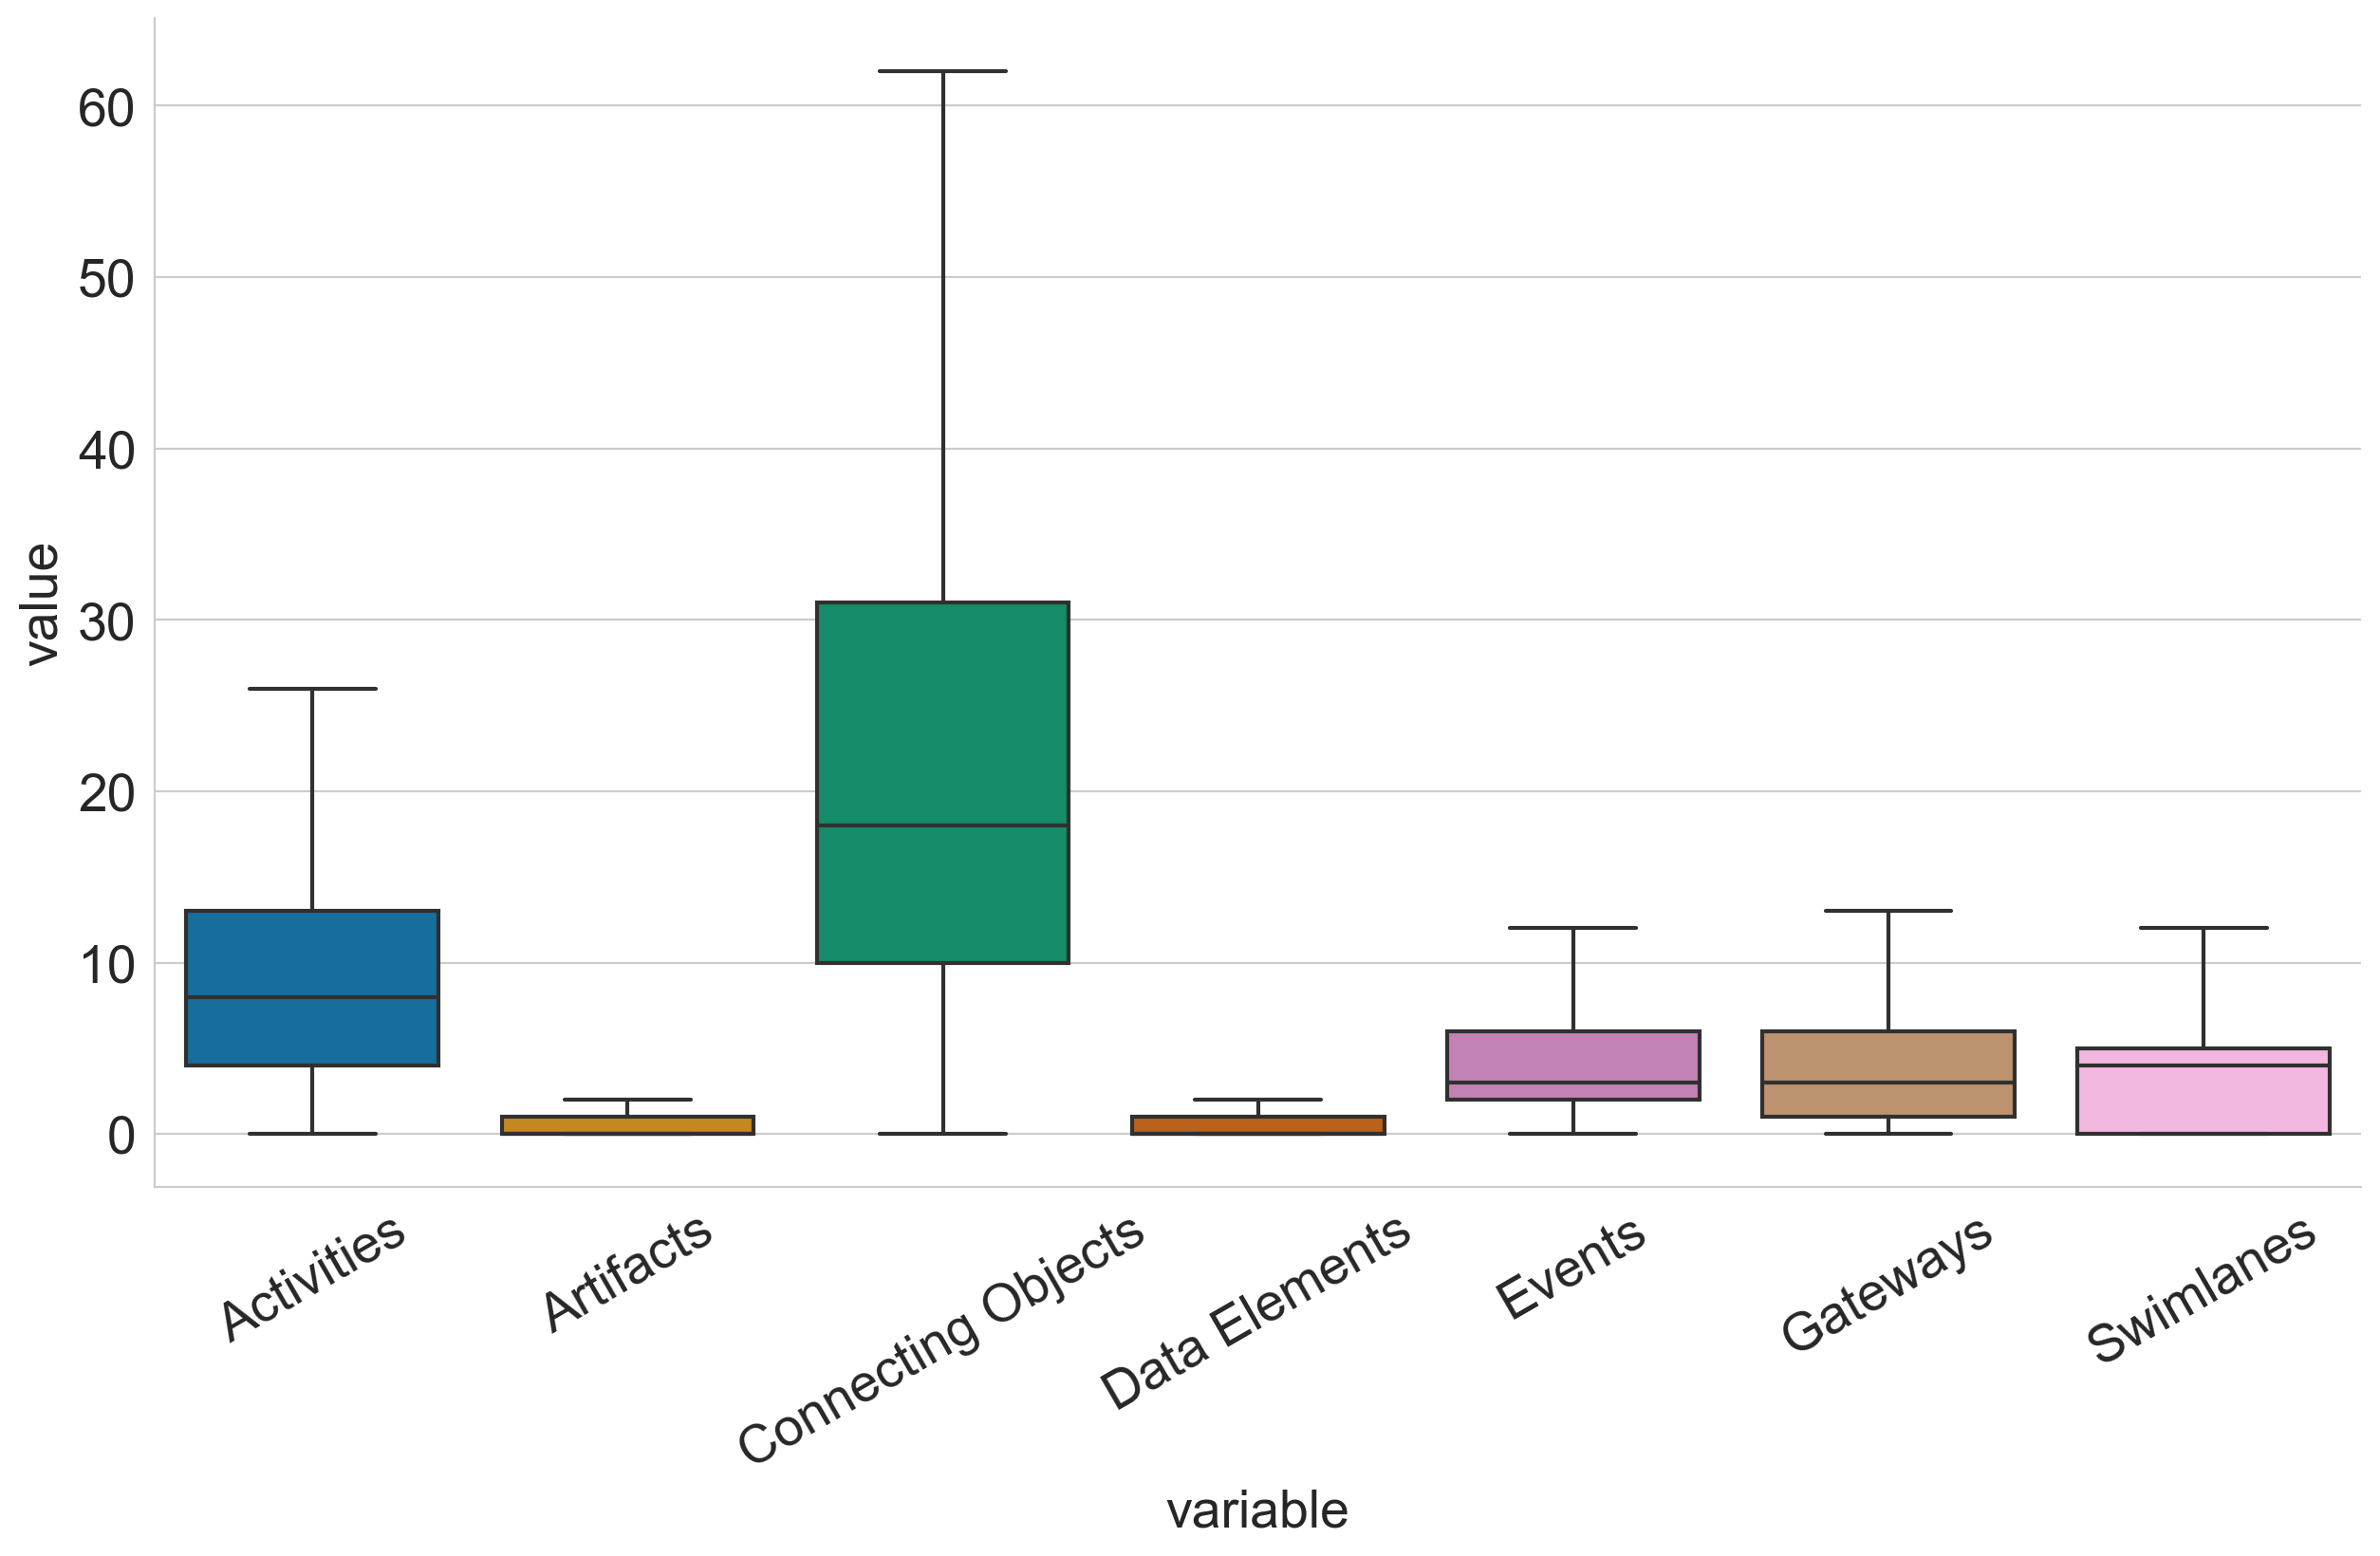

In [69]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [70]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%     max
No. of Edges  50151.0  24.770712  26.458218  0.0  10.0  18.0  31.0  1393.0
No. of Nodes  50151.0  25.776674  23.994112  0.0  12.0  20.0  32.0  1218.0

In [71]:
df_high_level.head()

No. of Edges  No. of Nodes
0             3             9
1            17            21
2             6             7
3            29            37
4             5             8

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

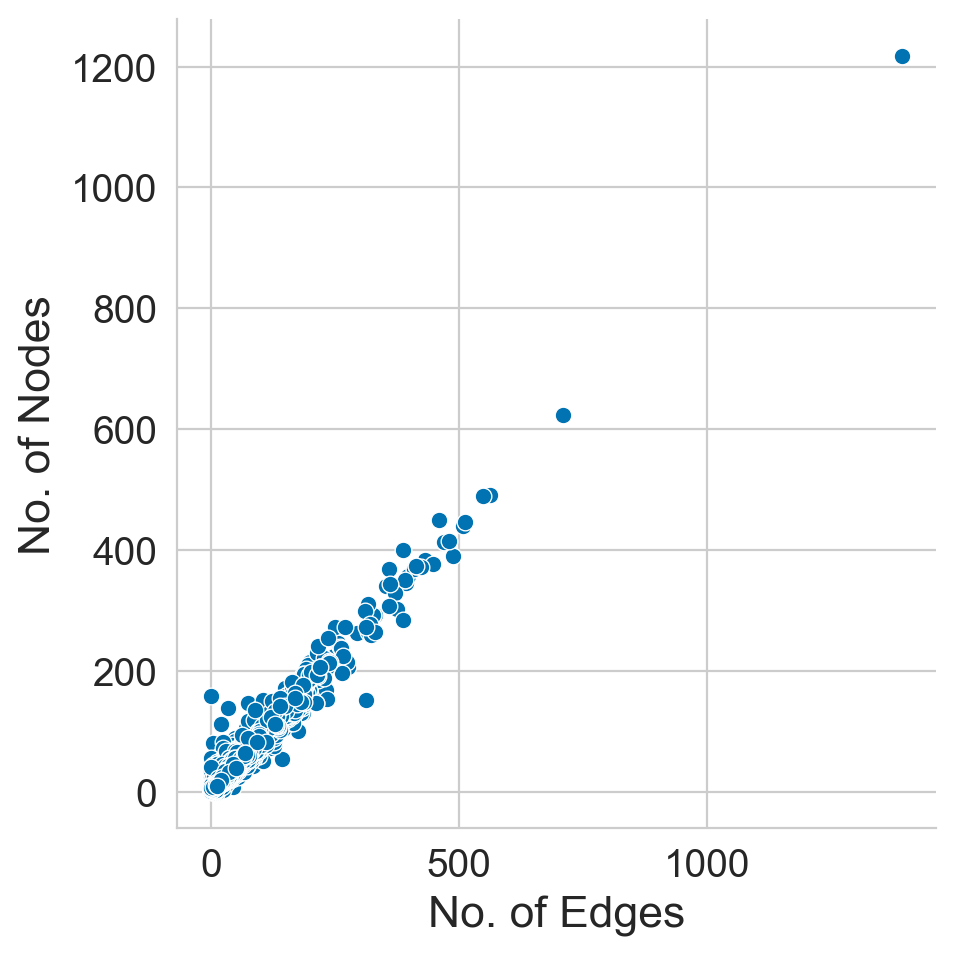

In [72]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [73]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [74]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0       12345678         3127
1    New Process         1728
2  Neuer Prozess          602
3  12345678_rev1          338
4  12345678_rev2          211
5       Jane Doe          172
6    New Diagram          149
7  12345678_rev3          146
8           BPMN          111
9  12345678_rev4          101

The number of distinct process names:

In [75]:
len(cnts_names)

52115

We use Signavio's color palette for the word cloud.

In [76]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

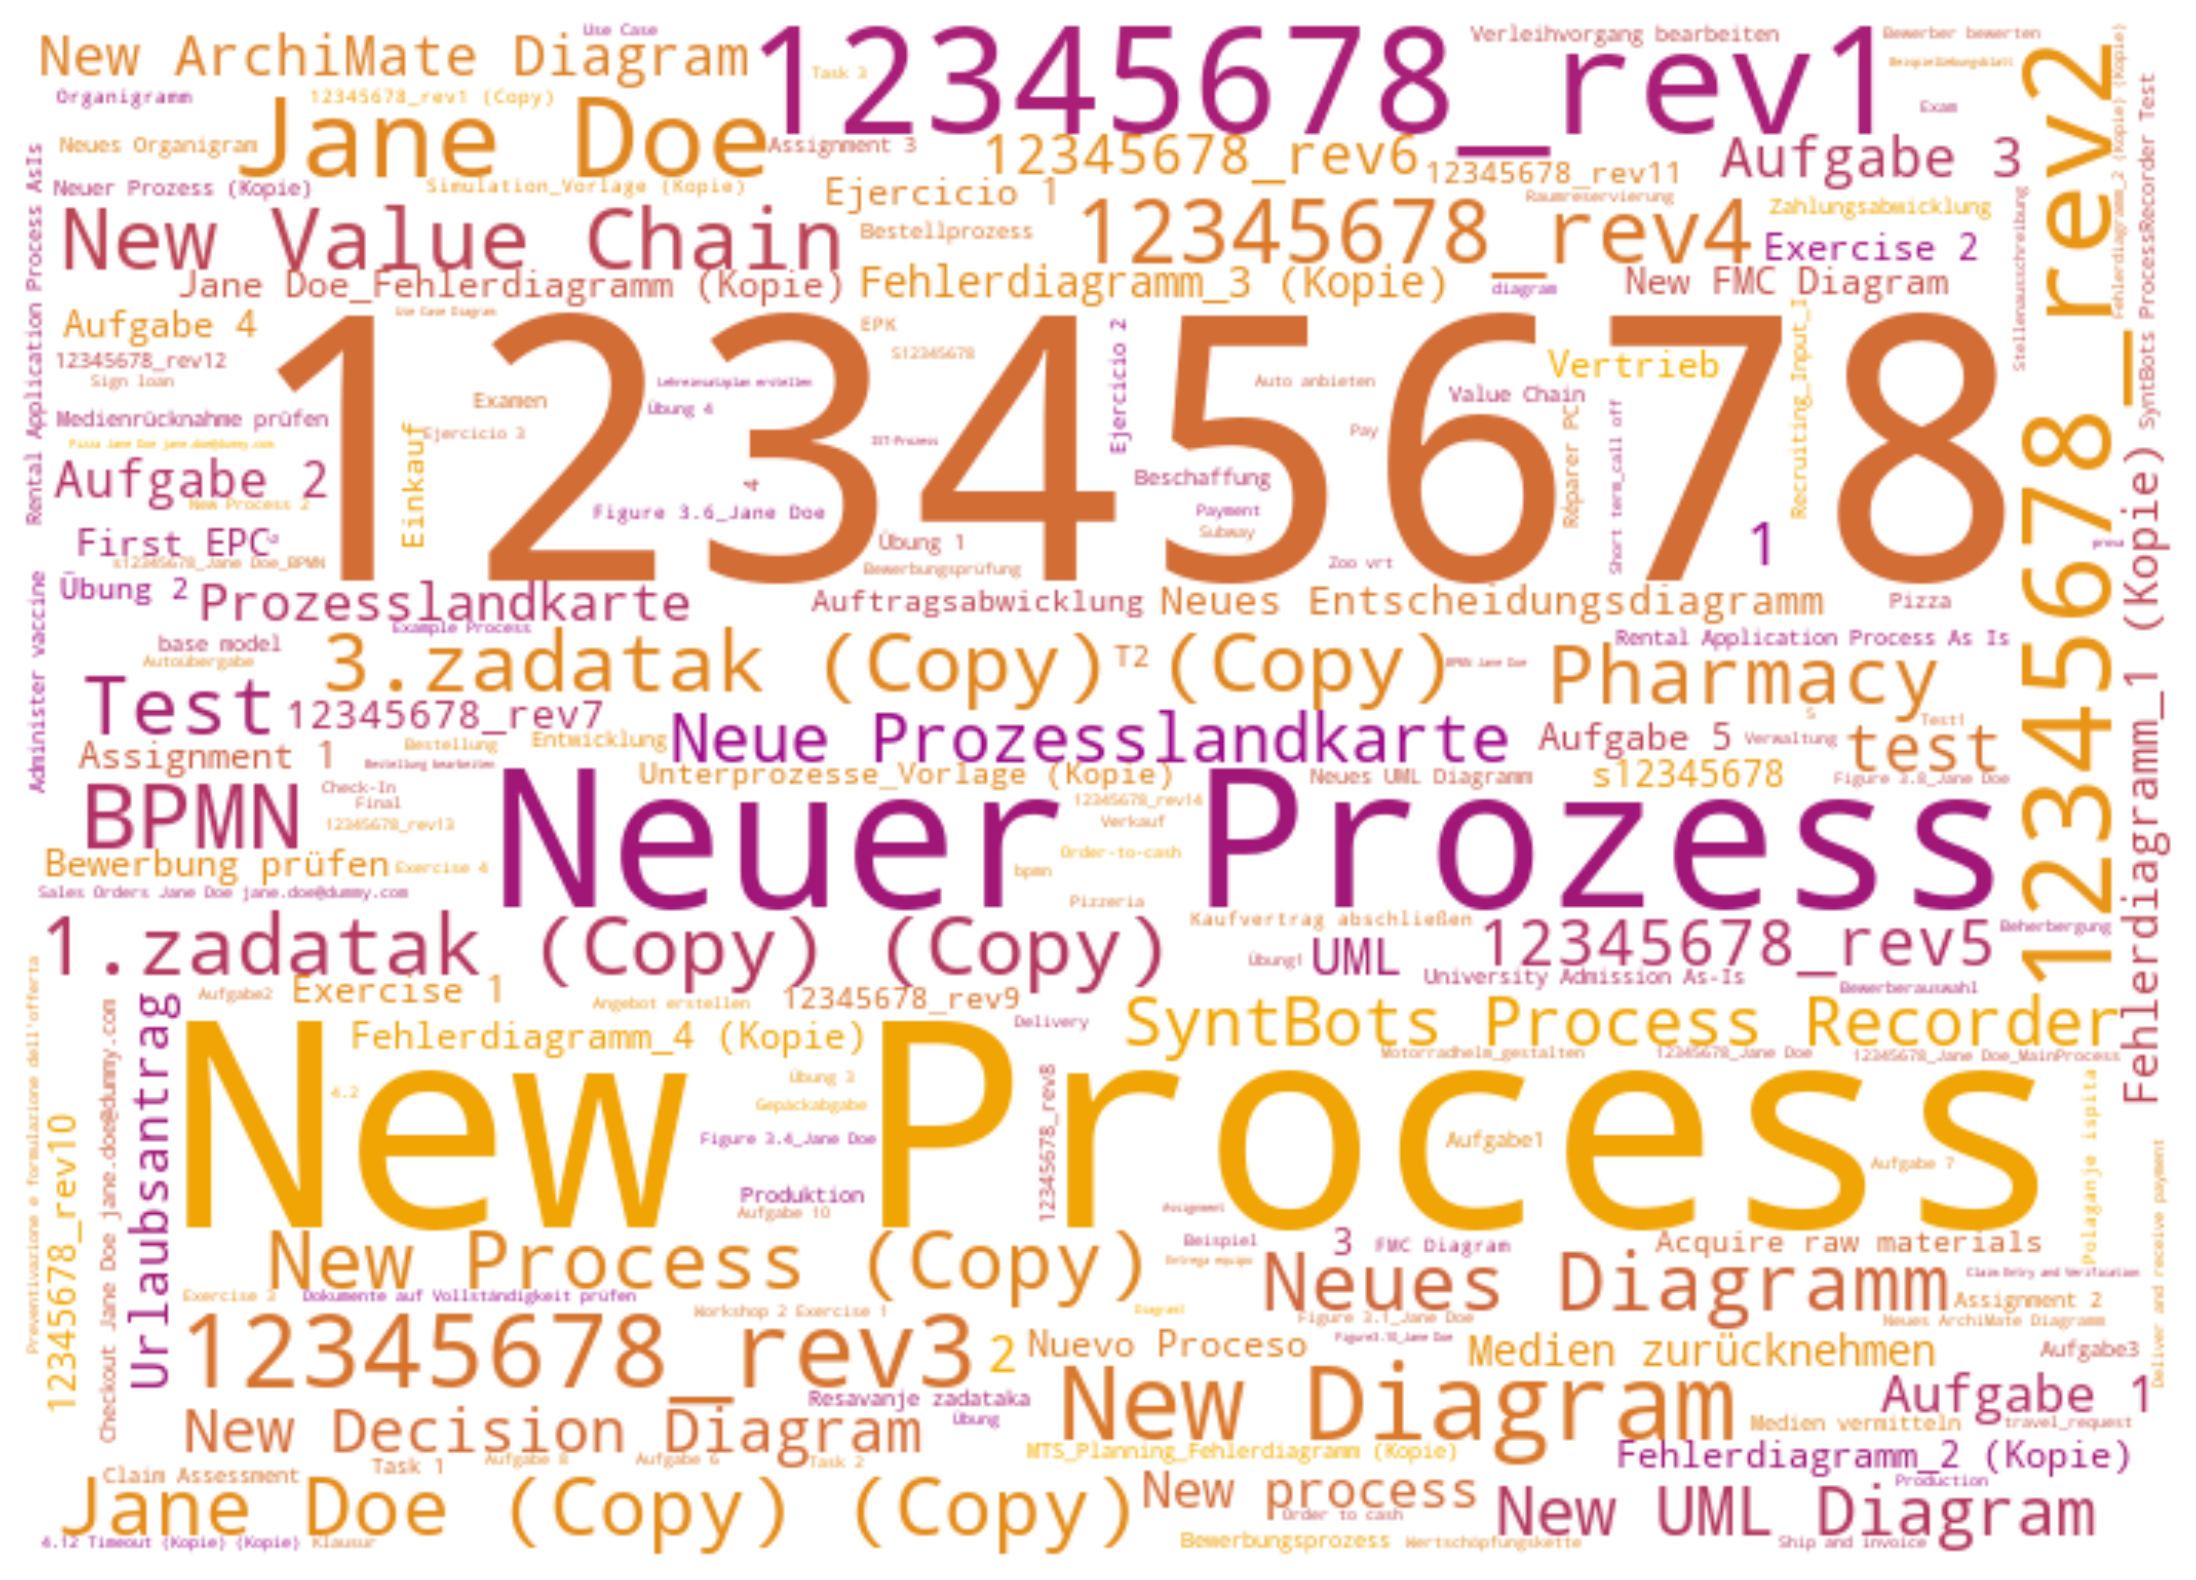

In [77]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [78]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No        14792
1       Yes        12050
2        Ja         6369
3      Nein         5893
4        no         5881
5        ja         5070
6      nein         5022
7       yes         4780
8  Customer         3136
9        NO         2770

The number of distinct element labels:

In [79]:
len(cnts_labels)

598301

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [80]:
len(df_bpmn)

2535068

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [81]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.4935843102536178

... while 64.9 % of the labels are used for only one element.

In [82]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.7904048296760326

In [83]:
len(cnts_labels[cnts_labels.occurrences==1])

472900

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [84]:
bins = cnts_labels
bins.head()

label  occurrences
0    No        14792
1   Yes        12050
2    Ja         6369
3  Nein         5893
4    no         5881

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [85]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [86]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0       391697           10000
1        65412           20000
2        43618           30000
3        33813           40000
4        30000           50000

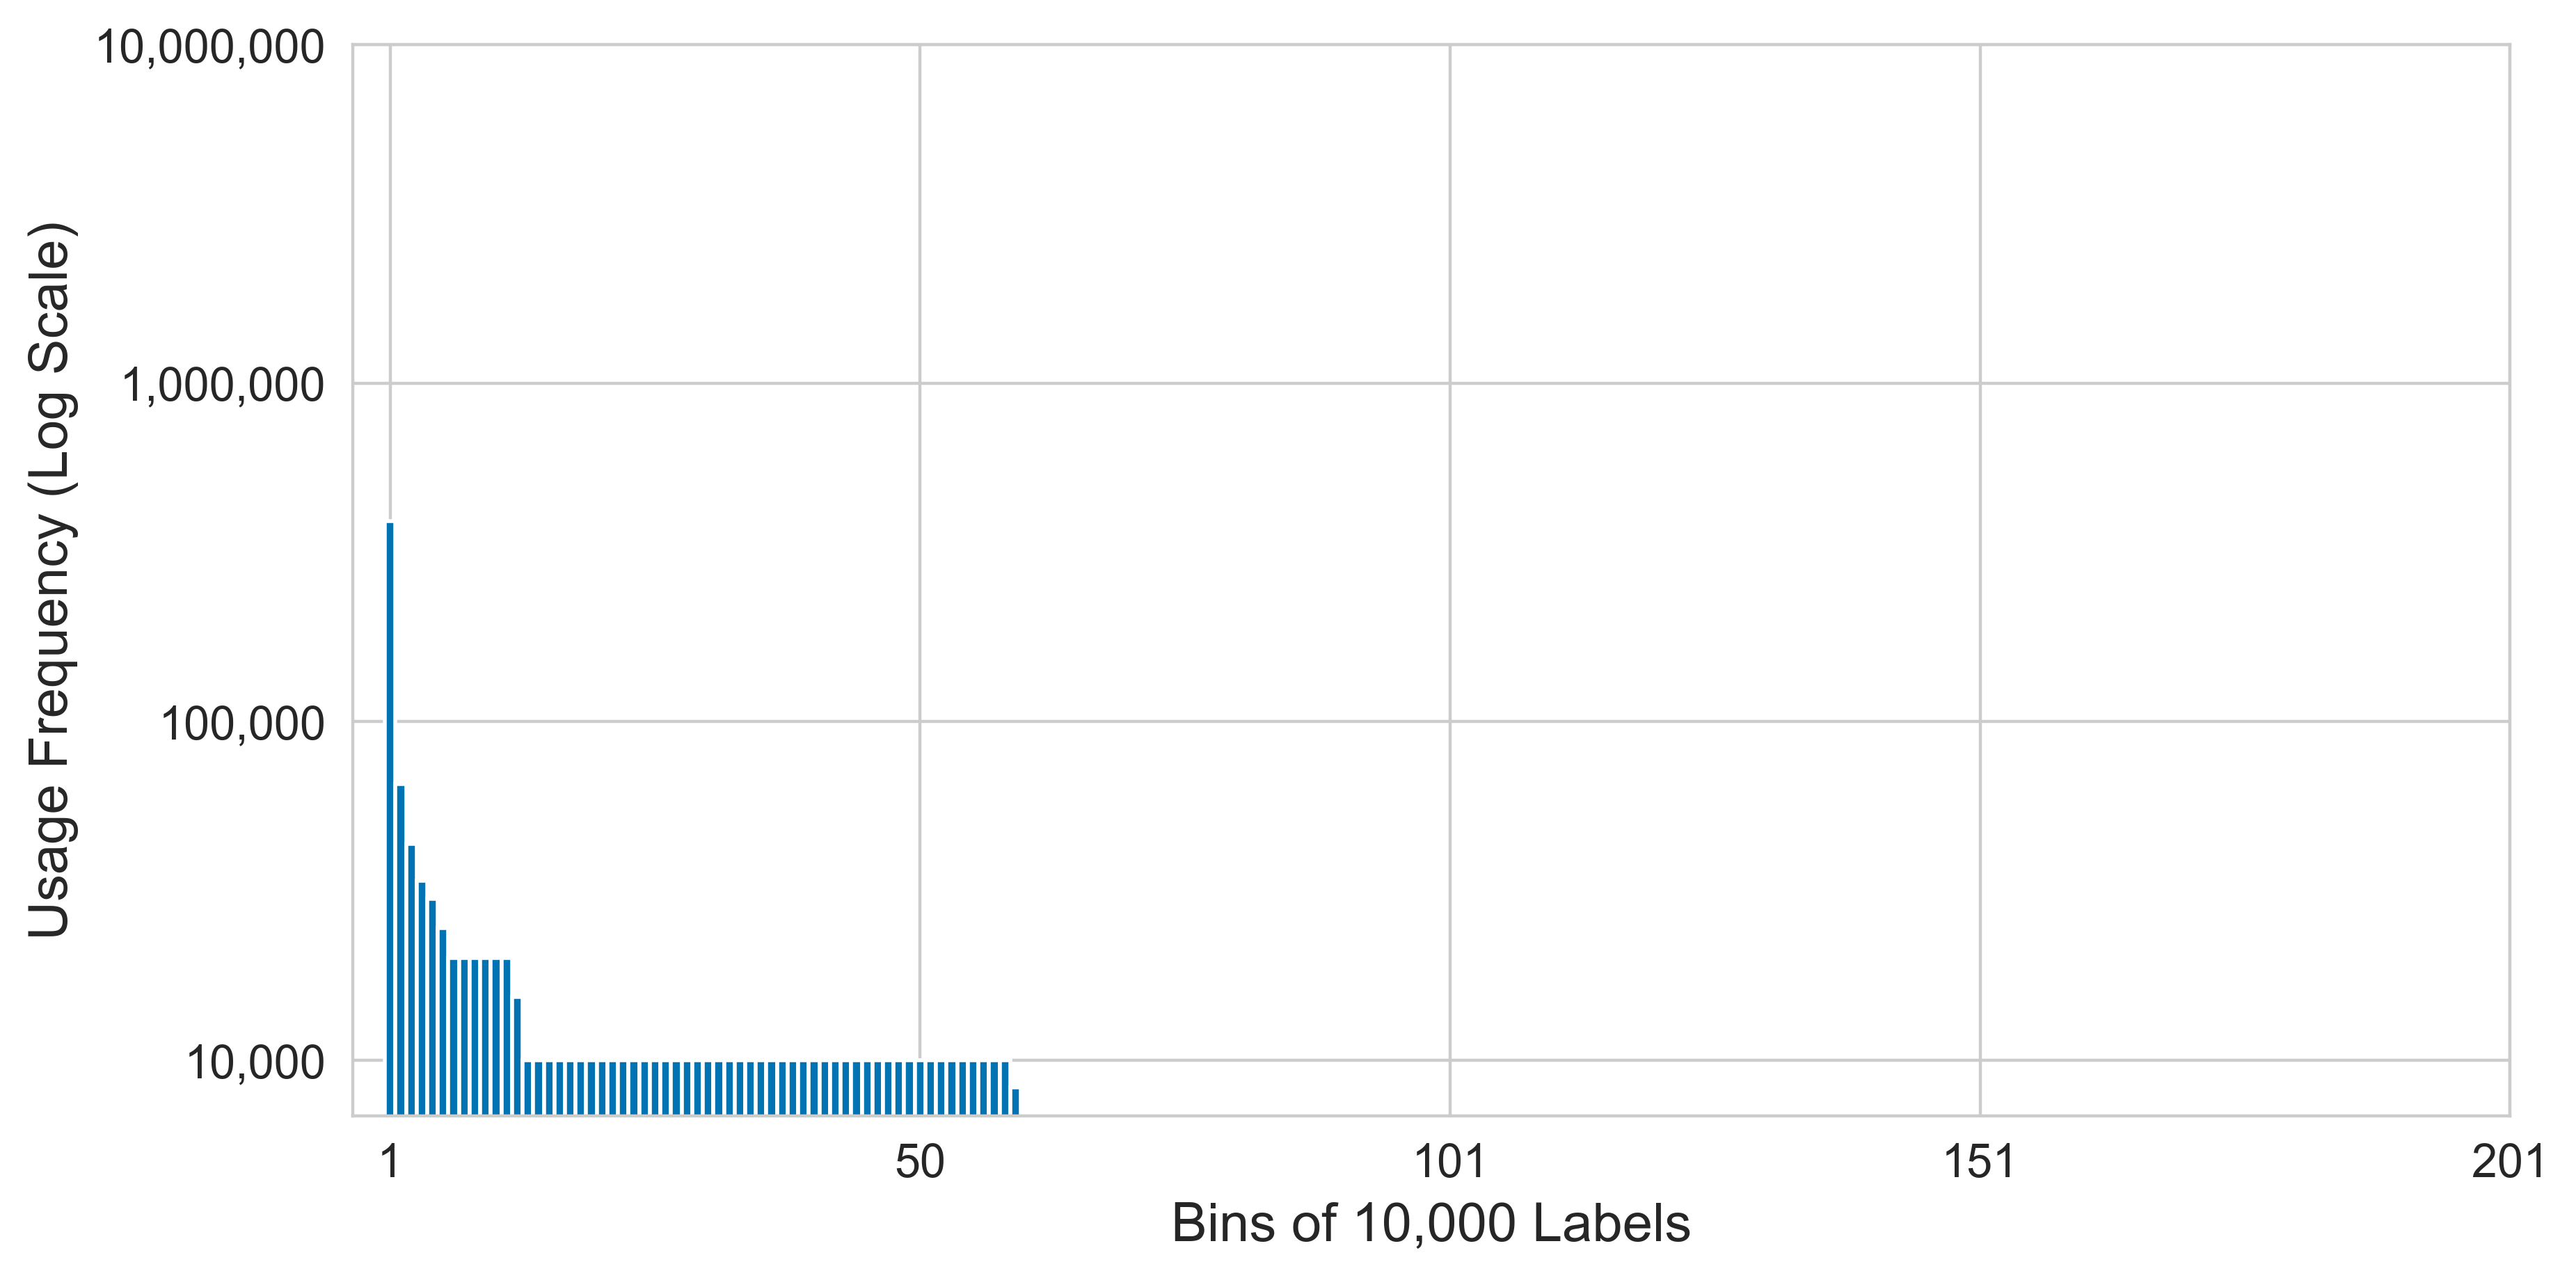

In [87]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

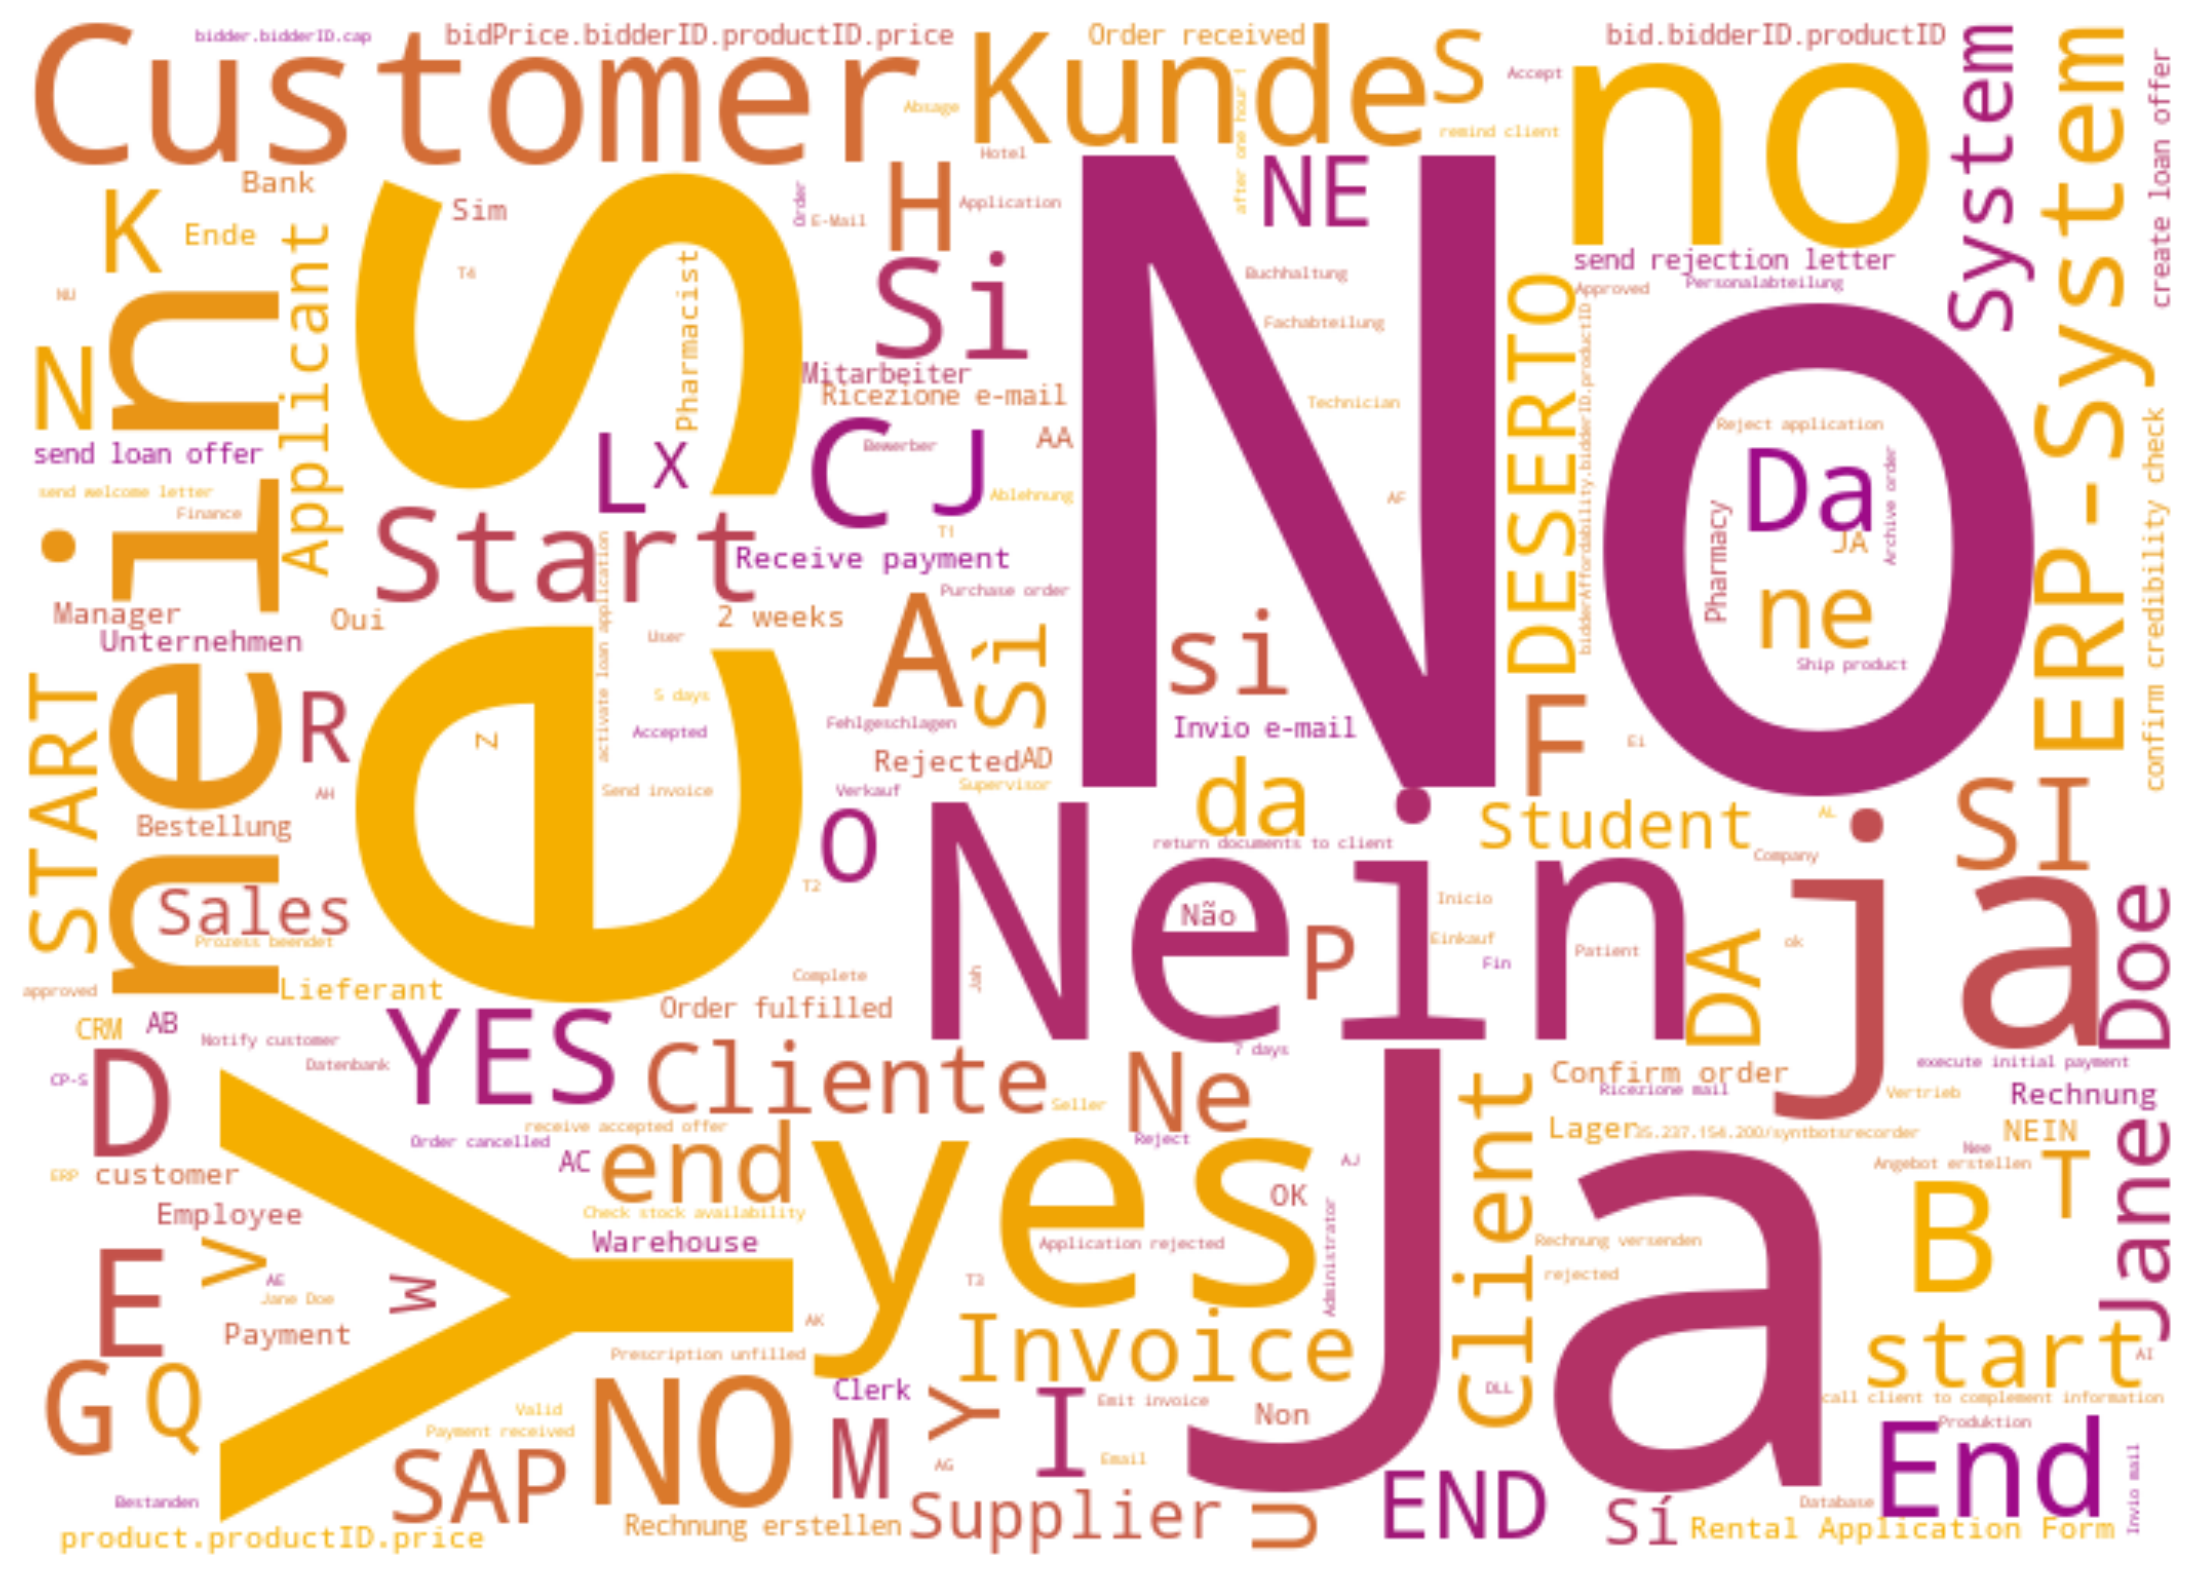

In [88]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()